In [ ]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()
end_date = '2023-09-27'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)
df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()
df

[*********************100%***********************]  503 of 503 completed

3 Failed downloads:
['GEV', 'VLTO', 'SOLV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-09-29 00:00:00 -> 2023-09-27) (Yahoo error = "Data doesn\'t exist for startDate = 1443499200, endDate = 1695787200")')


In [2]:
'''
The Main strategy we will use for portfolio managment is by clustering various measurements extracted from our downlaoded data as well as data from world trends
'''

df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['close'])-np.log(df['open']))**2)
# a volatility measure 
df['rsi'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))
# the heigher the rsi the more ovebrought and the lower the more underrated. IN general sell for values >70 andbuy for values<30
df['bb_low'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])              
df['bb_mid'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])                     
df['bb_high'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])
# bb bands are another way to analyise stock perfomrance. We take the average of the stock price within a given rrange of time as well as 
#an upper bound and lwoer bound absed on standard deviation
# can be used for similar purposes like RSI. VOlatily is properotional to band width and the distance of price form topor bottom
# incidcates undersellness and above sellness
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)
# atr is another measure of volatilty! it takes into account the last14 days
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())
# MACD is cmomplicated. It consists of 2 lines, the MACD line and anothe rline, calculated over different time perdios. WWHen the macd line is over the signal
# line, stocks going up, else down
# Being above zeor menas a bullish trend
# belwo zero means bearish
df['macd'] = df.groupby(level=1, group_keys=False)['close'].apply(compute_macd)

df['dollar_volume'] = (df['close']*df['volume'])/1e6
# this is simple. It shows how much a stock is being bought and sold. We are viding to nromalize
df

Price              adj close       close        high         low        open  \
date       ticker                                                              
2015-09-29 A             NaN   31.185329   31.481100   30.723188   30.834101   
           AAPL          NaN   24.536383   25.537547   24.266407   25.384560   
           ABBV          NaN   34.760983   35.682848   34.161769   34.965109   
           ABT           NaN   32.674088   33.211764   32.285306   32.475560   
           ACGL          NaN   23.217773   23.255808   22.916655   22.983217   
...                      ...         ...         ...         ...         ...   
2023-09-26 XYZ           NaN   44.810001   45.740002   44.560001   44.939999   
           YUM           NaN  119.860710  120.566281  119.319442  120.083010   
           ZBH           NaN  110.513580  115.083101  110.474272  114.748982   
           ZBRA          NaN  223.960007  226.649994  222.580002  225.970001   
           ZTS           NaN  173.026108  174.571772  172.439156  172.742417   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0          0.000247        NaN       NaN   
           AAPL    293461600.0          0.000857        NaN       NaN   
           ABBV     12842800.0          0.000936        NaN       NaN   
           ABT      12287500.0          0.000386        NaN       NaN   
           ACGL      1888800.0          0.000068        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYZ      10168200.0          0.000338  25.939817  3.799574   
           YUM       1500600.0          0.000053  36.057149  4.792448   
           ZBH       3610500.0          0.000289  31.893236  4.736766   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000075  42.623450  5.141724   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.241836  
           AAPL         NaN       NaN       NaN       NaN    7200.486118  
           ABBV         NaN       NaN       NaN       NaN     446.428346  
           ABT          NaN       NaN       NaN       NaN     401.482850  
           ACGL         NaN       NaN       NaN       NaN      43.853730  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYZ     3.980555  4.161536 -0.637443 -0.990293     455.637056  
           YUM     4.822408  4.852369  0.273231 -1.363696     179.862982  
           ZBH     4.776429  4.816093 -0.317023 -0.881067     399.009282  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.200533  5.259341  0.688219 -1.188279     253.171801  

[981146 rows x 14 columns]

In [3]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'adj close']]
# we gonna void these when making our new data
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()
# we are redoing this so the mean dollar volumes for one month and the last values of every other measurment are places in the new monthly aggregate
data

dollar_volume       close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          134.704655   38.653542          0.000050  73.421433   
           AAPL      4005.252755   26.729132          0.000095  55.537334   
           ABBV       322.941664   38.643803          0.000362  49.376862   
           ABT        206.572099   37.373230          0.000043  56.962608   
           ACGL        28.174423   22.970539          0.000078  35.682522   
...                          ...         ...               ...        ...   
2023-09-30 EXE        116.692165   79.277847          0.000084  44.326456   
           COIN       506.942443   70.519997          0.001007  39.839731   
           CEG        195.364205  107.145676          0.000274  55.245480   
           GEHC       211.835324   65.992226          0.000185  40.922355   
           KVUE       646.497250   19.281166          0.000158  35.706318   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.536749  3.609179  3.681609 -1.042156  0.567157  
           AAPL    3.277189  3.320493  3.363798 -0.976120 -0.142789  
           ABBV    3.683500  3.731698  3.779896 -0.758485  0.145677  
           ABT     3.632364  3.654204  3.676044 -1.097933  0.335557  
           ACGL    3.177974  3.195190  3.212406 -1.155694 -0.550166  
...                     ...       ...       ...       ...       ...  
2023-09-30 EXE     4.369459  4.422967  4.476475 -0.890970 -0.831788  
           COIN    4.273572  4.378785  4.483998 -1.183735  0.049978  
           CEG     4.645547  4.685718  4.725889 -0.396678  0.366876  
           GEHC    4.153380  4.210914  4.268448 -0.892834 -1.116462  
           KVUE    2.979201  3.054020  3.128840 -0.872137 -1.435621  

[46327 rows x 9 columns]

In [4]:
'''
Our next goal is to find out which of our stocks is th emost liquidated, we do this by ranking our data based on dollar volume.
THis is essenital as we dont want to play with useless stocks.
'''
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAPL     26.090458          0.000041  49.891092  3.289745   
           ABBV     38.501827          0.000192  27.477596  3.710224   
           ABT      33.469254          0.000024  38.008777  3.531008   
           ACN     101.253746          0.000033  53.823651  4.614949   
           ADBE    107.510002          0.000059  53.668389  4.679513   
...                       ...               ...        ...       ...   
2023-09-30 DDOG     86.570000          0.000314  37.040091  4.476874   
           PLTR     13.960000          0.000214  41.544692  2.701939   
           DASH     74.580002          0.000326  36.955365  4.329191   
           ABNB    132.279999          0.000213  44.494127  4.857047   
           COIN     70.519997          0.001007  39.839731  4.273572   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAPL    3.318620  3.347495 -1.035852 -0.195978  
           ABBV    3.764332  3.818440 -0.986698 -0.760593  
           ABT     3.581448  3.631888 -1.053542 -0.650888  
           ACN     4.626584  4.638219 -0.999633 -0.135456  
           ADBE    4.694639  4.709766 -1.230331 -0.109039  
...                     ...       ...       ...       ...  
2023-09-30 DDOG    4.560278  4.643681 -0.867969 -0.699392  
           PLTR    2.779743  2.857548 -0.426167 -0.433581  
           DASH    4.403906  4.478620 -1.145418 -0.117919  
           ABNB    4.940924  5.024801 -1.006939 -0.037854  
           COIN    4.378785  4.483998 -1.183735  0.049978  

[12516 rows x 8 columns]

In [5]:
def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]
    for lag in lags:
        df[f'return_{lag}m'] = (df['close']
                              .pct_change(lag)#like diff, but gives difference over intervals based on lag
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))# this is to get rid of outliers
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAPL     39.529037          0.000112  69.196760  3.590193   
           ABBV     64.567619          0.000173  55.247806  4.153099   
           ABT      47.327888          0.000036  53.844800  3.868742   
           ACN     126.506287          0.000019  69.365281  4.780248   
           ADBE    175.160004          0.000067  70.089317  4.951759   
...                       ...               ...        ...       ...   
2023-09-30 DDOG     86.570000          0.000314  37.040091  4.476874   
           PLTR     13.960000          0.000214  41.544692  2.701939   
           DASH     74.580002          0.000326  36.955365  4.329191   
           ABNB    132.279999          0.000213  44.494127  4.857047   
           COIN     70.519997          0.001007  39.839731  4.273572   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAPL    3.637059  3.683926 -0.906565 -0.039275   0.096808   
           ABBV    4.199430  4.245761  0.053238  0.473815   0.022728   
           ABT     3.892300  3.915859 -1.039502  0.276132   0.021276   
           ACN     4.819920  4.859593 -0.977568  0.352343   0.064180   
           ADBE    5.089292  5.226825 -0.888269  0.612102   0.174152   
...                     ...       ...       ...       ...        ...   
2023-09-30 DDOG    4.560278  4.643681 -0.867969 -0.699392  -0.102716   
           PLTR    2.779743  2.857548 -0.426167 -0.433581  -0.068091   
           DASH    4.403906  4.478620 -1.145418 -0.117919  -0.113515   
           ABNB    4.940924  5.024801 -1.006939 -0.037854   0.005549   
           COIN    4.378785  4.483998 -1.183735  0.049978  -0.114070   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAPL     0.015249   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048455   0.037203   0.028692   0.027398    0.018728  
           ADBE     0.062497   0.061392   0.045993   0.049515    0.041515  
...                      ...        ...        ...        ...         ...  
2023-09-30 DDOG    -0.138786  -0.041732   0.029624   0.018352   -0.002098  
           PLTR    -0.161174  -0.030723   0.087272   0.090143    0.046083  
           DASH    -0.093658  -0.008091   0.027006   0.048207    0.034568  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  
           COIN    -0.154340  -0.004822   0.007147   0.079010    0.007477  

[10320 rows x 14 columns]

In [6]:
#Fama french factors are external factors are external factors based on which we can do better predcitions

factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data
# simply formatting fama french data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAPL    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.096808
           ABBV    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.022728
           ABT     0.0225 -0.0191  0.0013  0.0092 -0.0314   0.021276
           ACN     0.0225 -0.0191  0.0013  0.0092 -0.0314   0.064180
           ADBE    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.174152
...                   ...     ...     ...     ...     ...        ...
2023-09-30 WDAY   -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.062413
           WFC    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.015500
           WMT    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.000677
           XOM    -0.0523 -0.0178  0.0149  0.0187 -0.0077   0.046947
           XYZ    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.222723

[10320 rows x 6 columns]

In [7]:
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data
#We are goin throught eh famafrench values and removing stocks with less than 10  months observations

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAPL    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.096808
           ABBV    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.022728
           ABT     0.0225 -0.0191  0.0013  0.0092 -0.0314   0.021276
           ACN     0.0225 -0.0191  0.0013  0.0092 -0.0314   0.064180
           ADBE    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.174152
...                   ...     ...     ...     ...     ...        ...
2023-09-30 WDAY   -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.062413
           WFC    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.015500
           WMT    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.000677
           XOM    -0.0523 -0.0178  0.0149  0.0187 -0.0077   0.046947
           XYZ    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.222723

[10301 rows x 6 columns]

In [8]:
'''
What are Betas? Betas are Are values which show the relaiotnshipsof the stock retrunw ith respect ot each fama french factor
for instance a beta of 1 with market returns show positive correlation of stock retunrs with amrket.
'''
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], # retun fro 1 mont
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)), # everything else exceprt the return
                                     window=min(24, x.shape[0]),# we calculte a rolling valu eof the betas over 24 items if possible
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))# redunat axis

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 WDAY    1.080889 -0.943888 -0.563591 -0.904332 -0.245654
           WFC     1.122065  0.240830  2.052975 -0.498808 -1.544765
           WMT     0.703877 -0.314958 -0.404471 -0.145428  0.500270
           XOM     0.983369 -1.133542  1.727317 -0.688368 -0.355504
           XYZ     2.417771  1.930175 -0.346912 -1.674851  0.482785

[10301 rows x 5 columns]

In [9]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10068 entries, (Timestamp('2017-10-31 00:00:00'), 'AAPL') to (Timestamp('2023-09-30 00:00:00'), 'DDOG')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10068 non-null  float64
 1   rsi               10068 non-null  float64
 2   bb_low            10068 non-null  float64
 3   bb_mid            10068 non-null  float64
 4   bb_high           10068 non-null  float64
 5   atr               10068 non-null  float64
 6   macd              10068 non-null  float64
 7   return_1m         10068 non-null  float64
 8   return_2m         10068 non-null  float64
 9   return_3m         10068 non-null  float64
 10  return_6m         10068 non-null  float64
 11  return_9m         10068 non-null  float64
 12  return_12m        10068 non-null  float64
 13  Mkt-RF            10068 non-null  float64
 14  SMB               10068 non-null  float64
 15  HML      

In [10]:
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAPL            0.000112  69.196760  3.590193  3.637059  3.683926   
           ABBV            0.000173  55.247806  4.153099  4.199430  4.245761   
           ABT             0.000036  53.844800  3.868742  3.892300  3.915859   
           ACN             0.000019  69.365281  4.780248  4.819920  4.859593   
           ADBE            0.000067  70.089317  4.951759  5.089292  5.226825   
...                             ...        ...       ...       ...       ...   
2023-09-30 XYZ             0.000338  25.939817  3.799574  3.980555  4.161536   
           MRNA            0.000146  38.747314  4.582514  4.685332  4.788149   
           UBER            0.000441  45.005268  3.806654  3.862227  3.917801   
           CRWD            0.000144  51.534803  5.026187  5.103696  5.181204   
           DDOG            0.000314  37.040091  4.476874  4.560278  4.643681   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAPL   -0.906565 -0.039275   0.096808   0.015249   0.044955   
           ABBV    0.053238  0.473815   0.022728   0.098590   0.091379   
           ABT    -1.039502  0.276132   0.021276   0.034308   0.034801   
           ACN    -0.977568  0.352343   0.064180   0.048455   0.037203   
           ADBE   -0.888269  0.612102   0.174152   0.062497   0.061392   
...                     ...       ...        ...        ...        ...   
2023-09-30 XYZ    -0.637443 -0.990293  -0.222723  -0.247423  -0.123607   
           MRNA   -0.529511 -0.376899  -0.132219  -0.086803  -0.068763   
           UBER   -0.746098 -0.133973  -0.062672  -0.053920   0.008422   
           CRWD   -0.744862  0.245950  -0.015641  -0.003656   0.029981   
           DDOG   -0.867969 -0.699392  -0.102716  -0.138786  -0.041732   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAPL     0.028875   0.038941    0.035228  1.276569 -0.251245   
           ABBV     0.056495   0.047273    0.044026  0.505458  0.360917   
           ABT      0.038672   0.031320    0.029294  0.833394 -0.194764   
           ACN      0.028692   0.027398    0.018728  1.203811 -0.154553   
           ADBE     0.045993   0.049515    0.041515  1.109843 -0.318357   
...                      ...        ...         ...       ...       ...   
2023-09-30 XYZ     -0.068630  -0.036876   -0.016915  2.425570  1.931592   
           MRNA    -0.071952  -0.064976   -0.015431  1.153178  0.830602   
           UBER     0.057244   0.066838    0.043691  1.089217  1.124109   
           CRWD     0.026391   0.047942   -0.002216  0.596191 -0.982986   
           DDOG     0.029624   0.018352   -0.002098  0.597929  1.152889   

                        HML       RMW       CMA  
date       ticker                                
2017-10-31 AAPL   -0.610475  0.680496  0.488773  
           ABBV   -0.030514  0.179041  0.188220  
           ABT    -0.528556  0.255642  0.985795  
           ACN    -0.339661  0.270191  0.196832  
           ADBE   -0.184547 -0.218160 -0.687488  
...                     ...       ...       ...  
2023-09-30 XYZ    -0.379994 -1.634597  0.504004  
           MRNA   -1.184440  0.622973  1.031970  
           UBER   -0.230914 -1.531753 -0.492249  
           CRWD   -0.702390 -2.504872 -0.806021  
           DDOG   -0.670874 -0.679475 -0.694354  

[10068 rows x 18 columns]

In [11]:
from sklearn.cluster import KMeans
#data = data.drop('cluster', axis=1)
target_rsi_values = [30, 45, 55, 70]
initial_centroids = np.zeros((len(target_rsi_values), 18))
initial_centroids[:, 6] = target_rsi_values

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAPL            0.000112  69.196760  3.590193  3.637059  3.683926   
           ABBV            0.000173  55.247806  4.153099  4.199430  4.245761   
           ABT             0.000036  53.844800  3.868742  3.892300  3.915859   
           ACN             0.000019  69.365281  4.780248  4.819920  4.859593   
           ADBE            0.000067  70.089317  4.951759  5.089292  5.226825   
...                             ...        ...       ...       ...       ...   
2023-09-30 XYZ             0.000338  25.939817  3.799574  3.980555  4.161536   
           MRNA            0.000146  38.747314  4.582514  4.685332  4.788149   
           UBER            0.000441  45.005268  3.806654  3.862227  3.917801   
           CRWD            0.000144  51.534803  5.026187  5.103696  5.181204   
           DDOG            0.000314  37.040091  4.476874  4.560278  4.643681   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAPL   -0.906565 -0.039275   0.096808   0.015249   0.044955   
           ABBV    0.053238  0.473815   0.022728   0.098590   0.091379   
           ABT    -1.039502  0.276132   0.021276   0.034308   0.034801   
           ACN    -0.977568  0.352343   0.064180   0.048455   0.037203   
           ADBE   -0.888269  0.612102   0.174152   0.062497   0.061392   
...                     ...       ...        ...        ...        ...   
2023-09-30 XYZ    -0.637443 -0.990293  -0.222723  -0.247423  -0.123607   
           MRNA   -0.529511 -0.376899  -0.132219  -0.086803  -0.068763   
           UBER   -0.746098 -0.133973  -0.062672  -0.053920   0.008422   
           CRWD   -0.744862  0.245950  -0.015641  -0.003656   0.029981   
           DDOG   -0.867969 -0.699392  -0.102716  -0.138786  -0.041732   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAPL     0.028875   0.038941    0.035228  1.276569 -0.251245   
           ABBV     0.056495   0.047273    0.044026  0.505458  0.360917   
           ABT      0.038672   0.031320    0.029294  0.833394 -0.194764   
           ACN      0.028692   0.027398    0.018728  1.203811 -0.154553   
           ADBE     0.045993   0.049515    0.041515  1.109843 -0.318357   
...                      ...        ...         ...       ...       ...   
2023-09-30 XYZ     -0.068630  -0.036876   -0.016915  2.425570  1.931592   
           MRNA    -0.071952  -0.064976   -0.015431  1.153178  0.830602   
           UBER     0.057244   0.066838    0.043691  1.089217  1.124109   
           CRWD     0.026391   0.047942   -0.002216  0.596191 -0.982986   
           DDOG     0.029624   0.018352   -0.002098  0.597929  1.152889   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAPL   -0.610475  0.680496  0.488773        2  
           ABBV   -0.030514  0.179041  0.188220        3  
           ABT    -0.528556  0.255642  0.985795        3  
           ACN    -0.339661  0.270191  0.196832        2  
           ADBE   -0.184547 -0.218160 -0.687488        2  
...                     ...       ...       ...      ...  
2023-09-30 XYZ    -0.379994 -1.634597  0.504004        0  
           MRNA   -1.184440  0.622973  1.031970        3  
           UBER   -0.230914 -1.531753 -0.492249        3  
           CRWD   -0.702390 -2.504872 -0.806021        2  
           DDOG   -0.670874 -0.679475 -0.694354        0  

[10068 rows x 19 columns]

In [12]:
def plot_clusters(data):
    i = 1
    j = 5
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,j] , cluster_0.iloc[:,i] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,j] , cluster_1.iloc[:,i] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,j] , cluster_2.iloc[:,i] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,j] , cluster_3.iloc[:,i] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


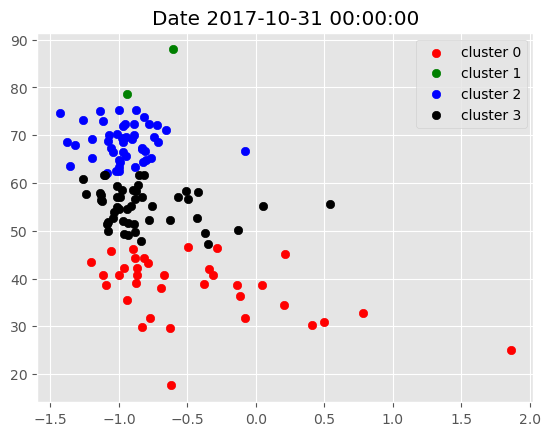

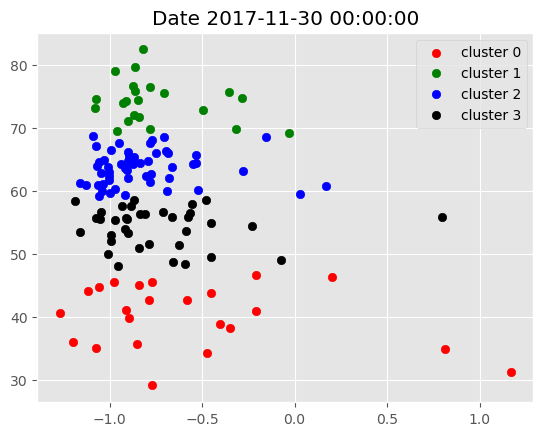

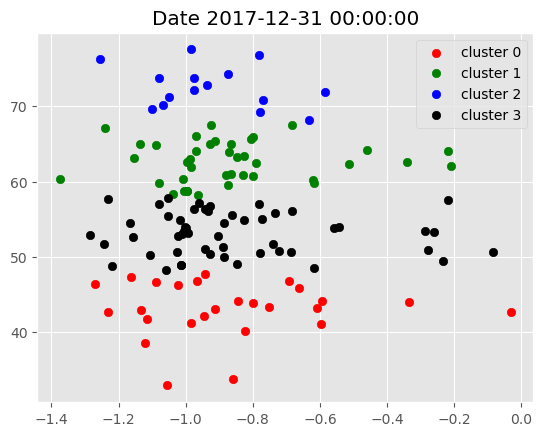

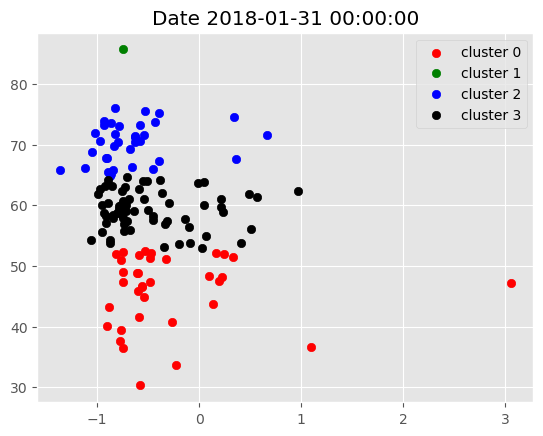

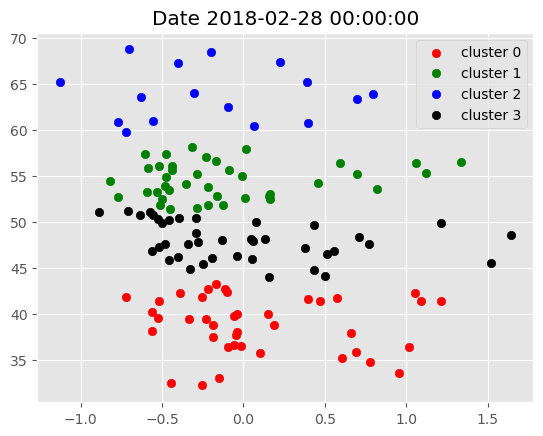

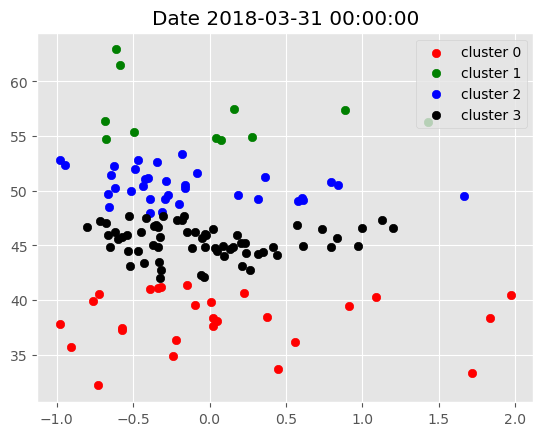

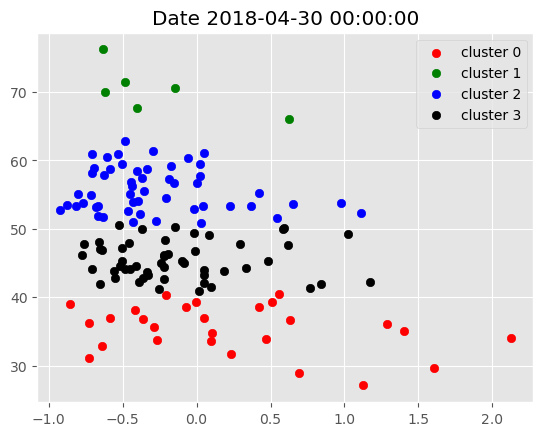

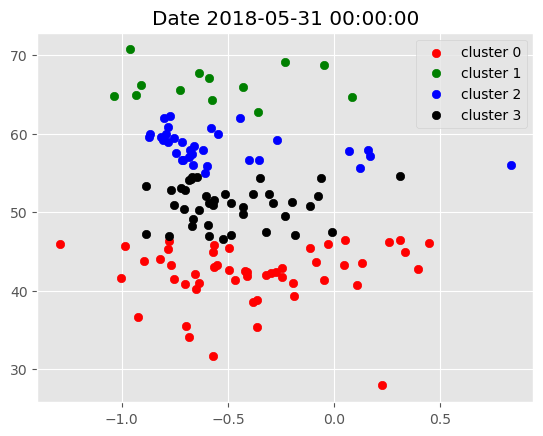

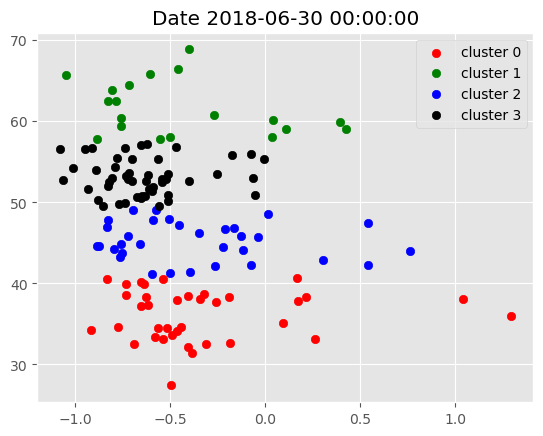

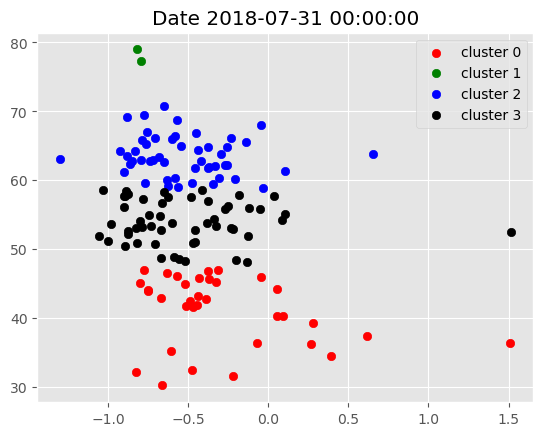

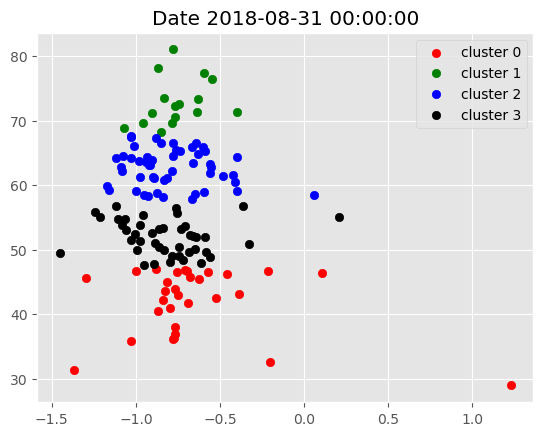

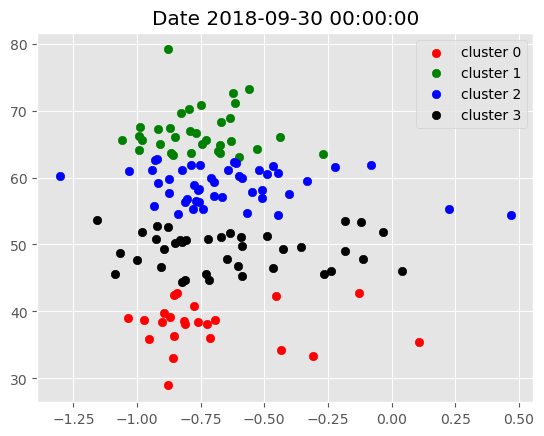

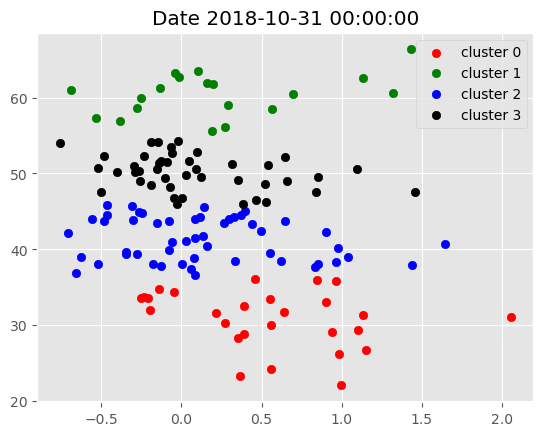

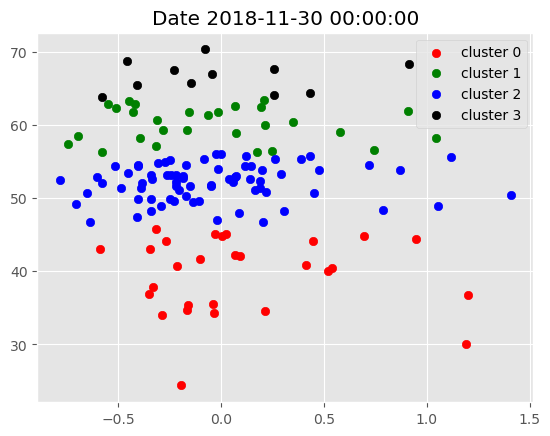

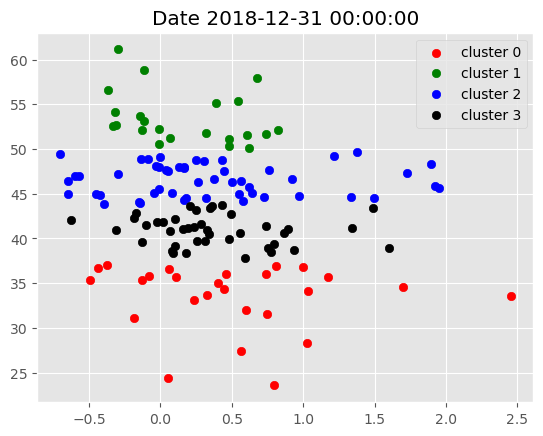

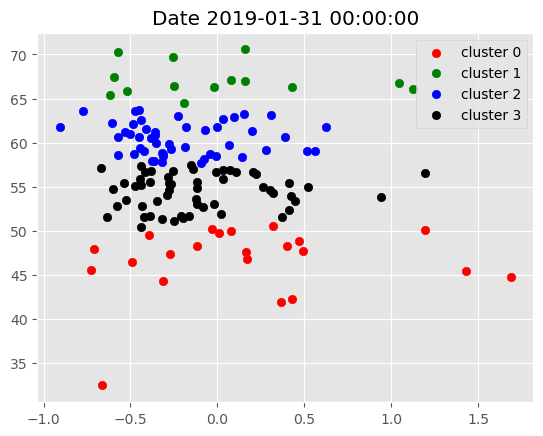

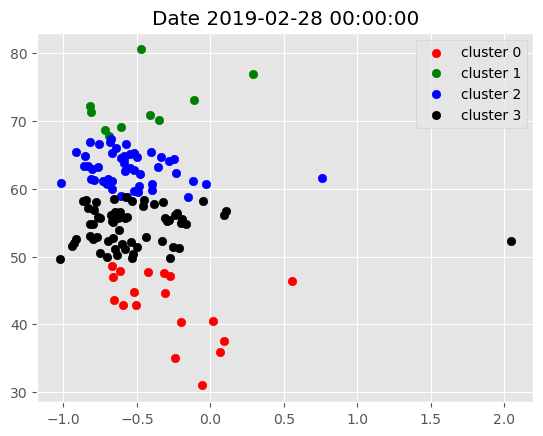

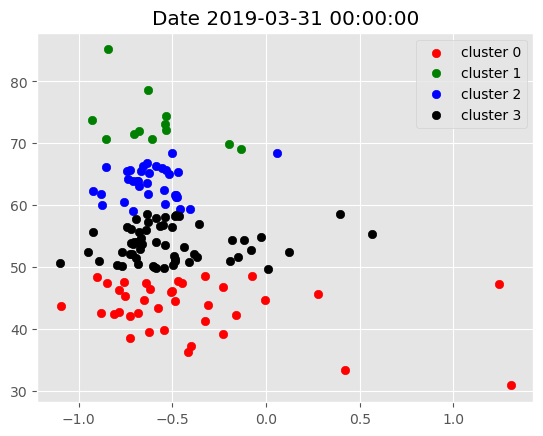

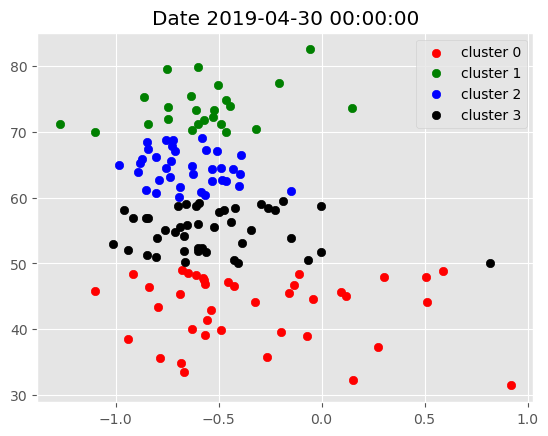

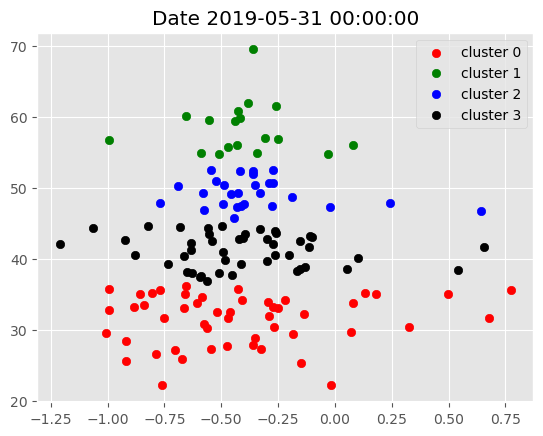

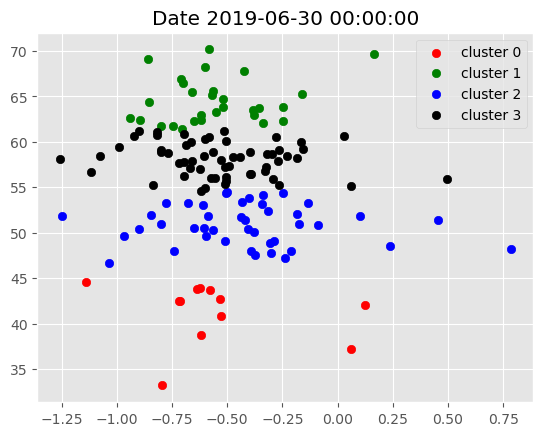

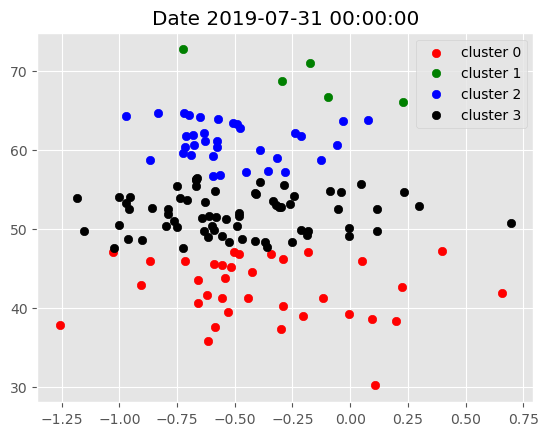

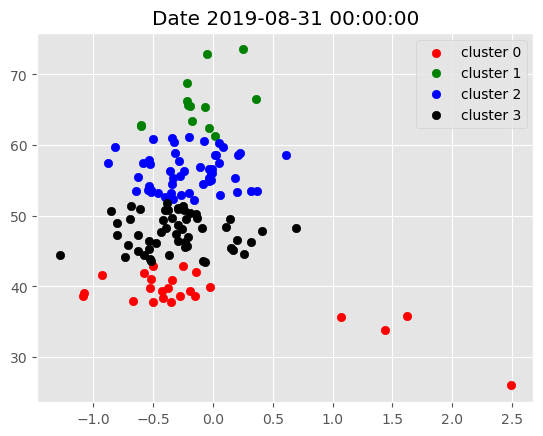

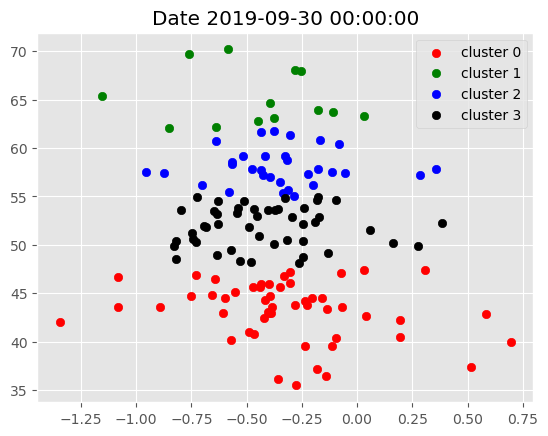

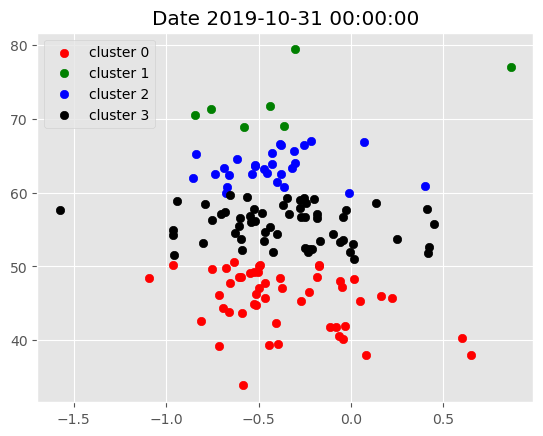

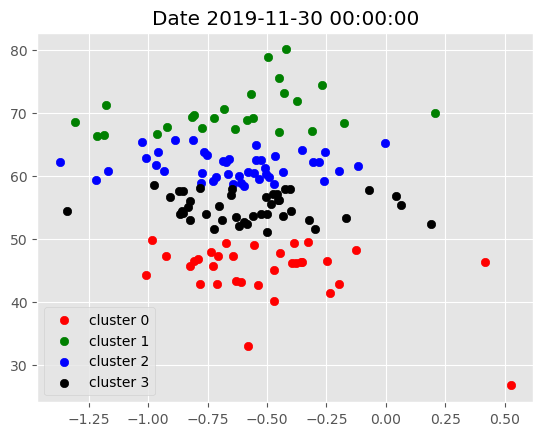

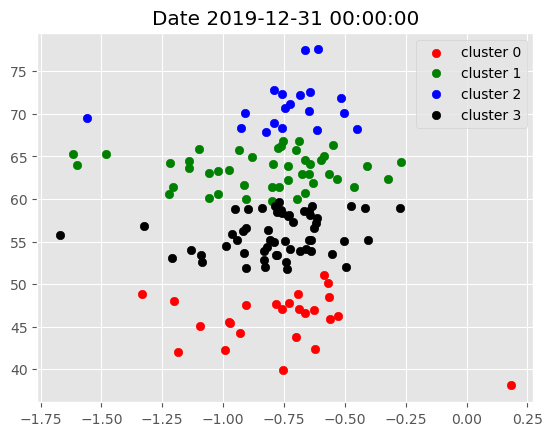

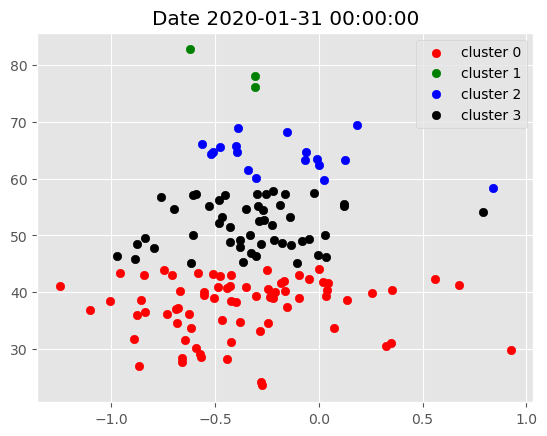

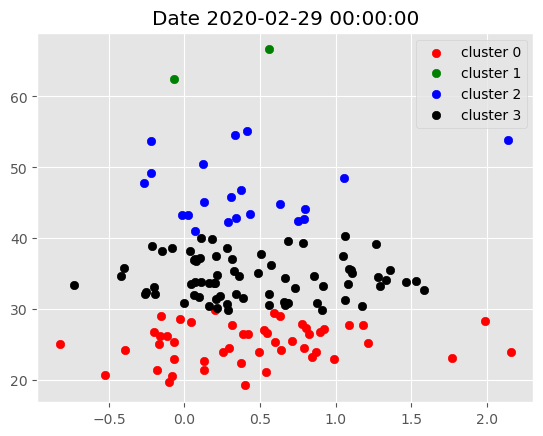

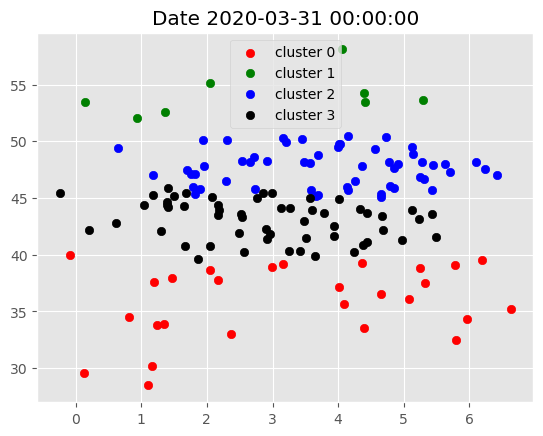

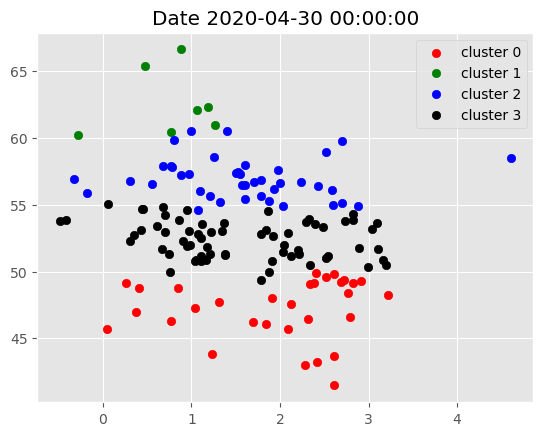

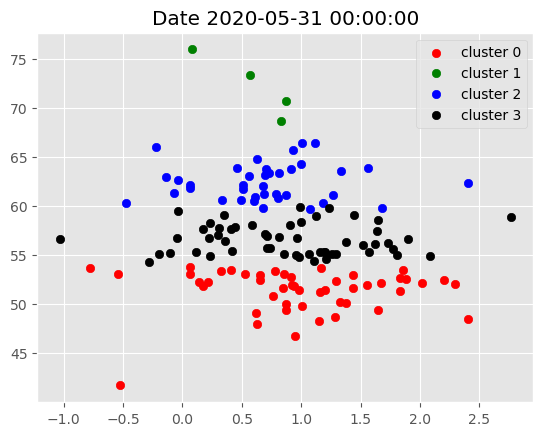

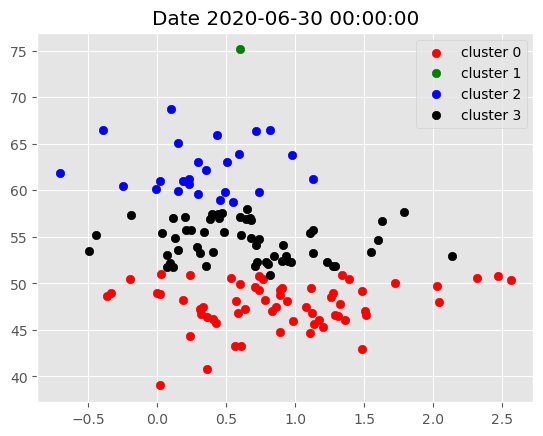

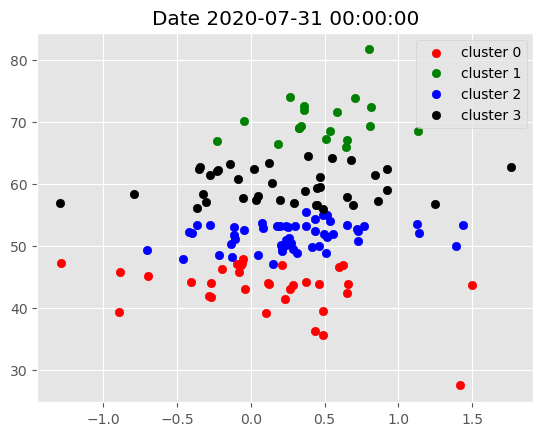

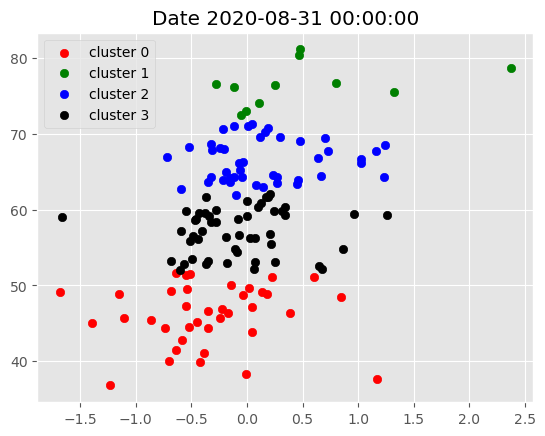

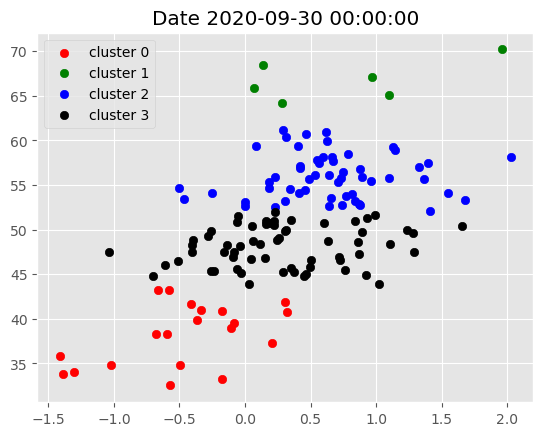

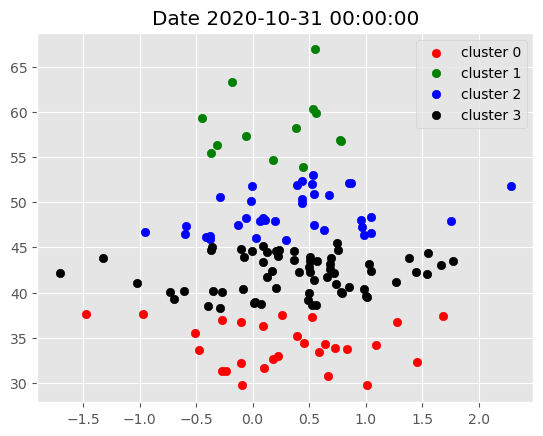

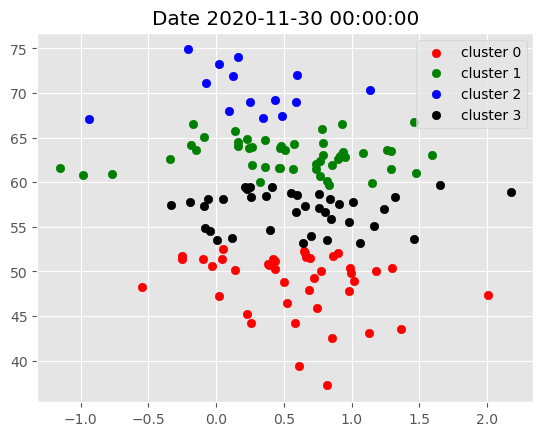

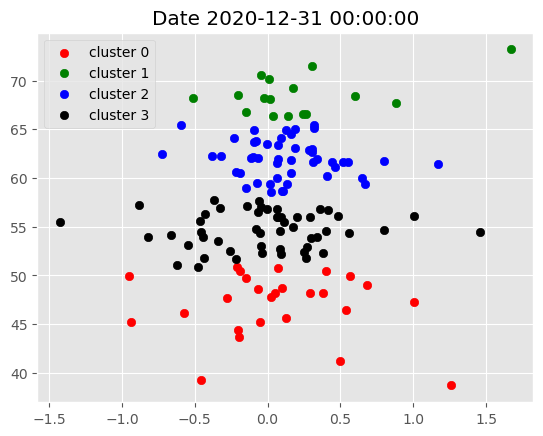

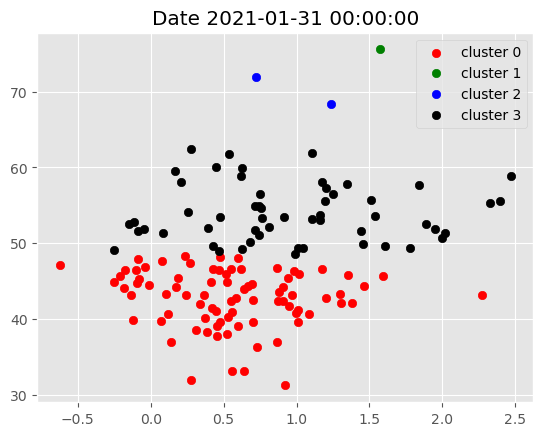

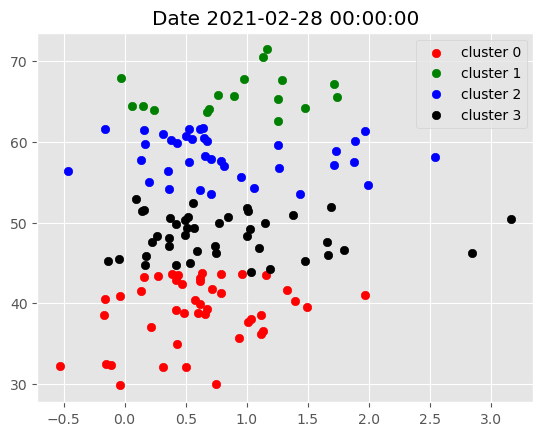

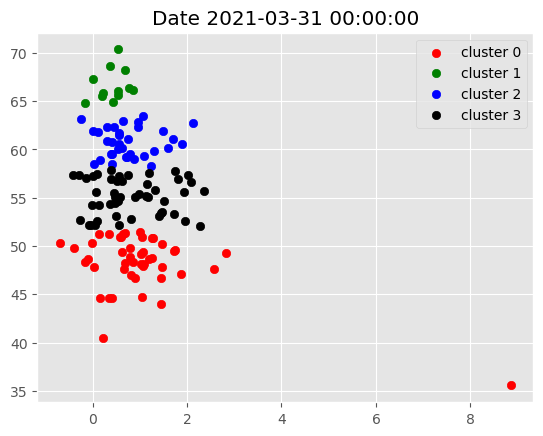

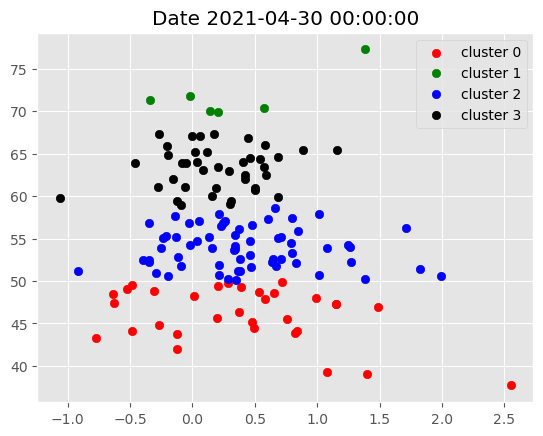

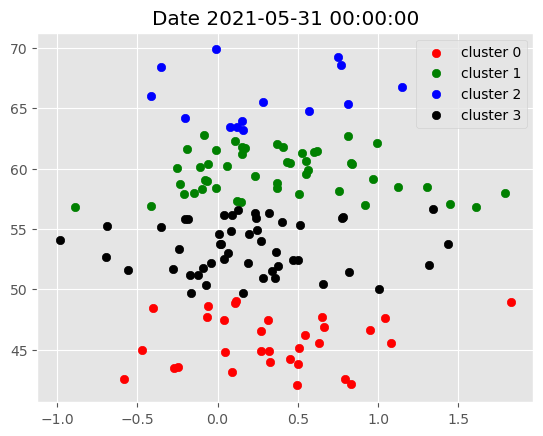

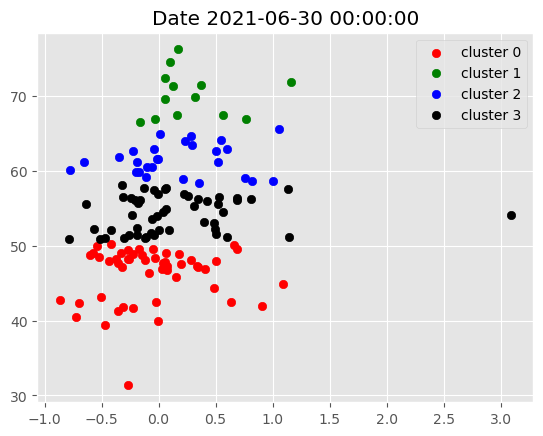

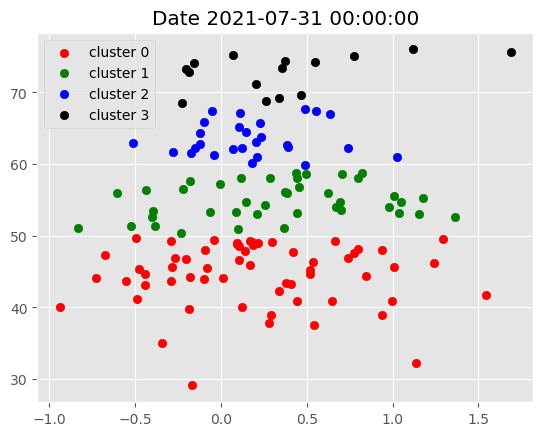

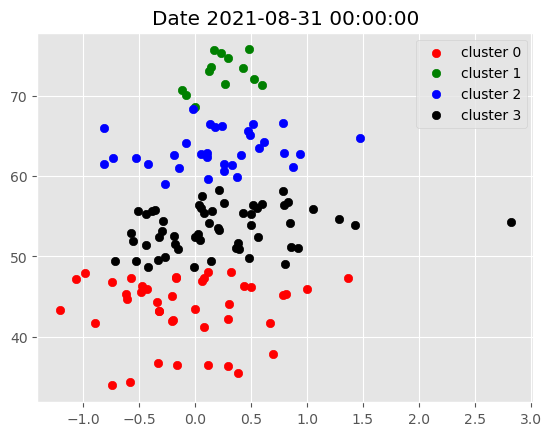

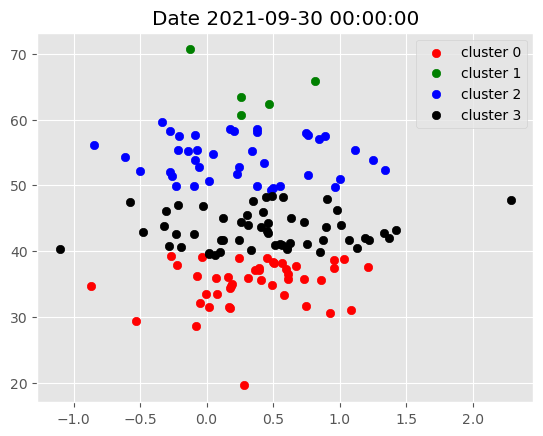

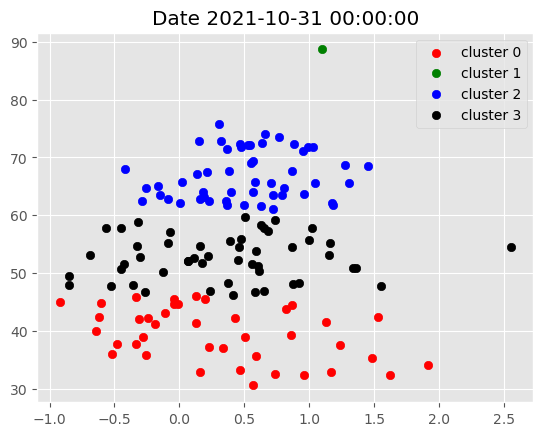

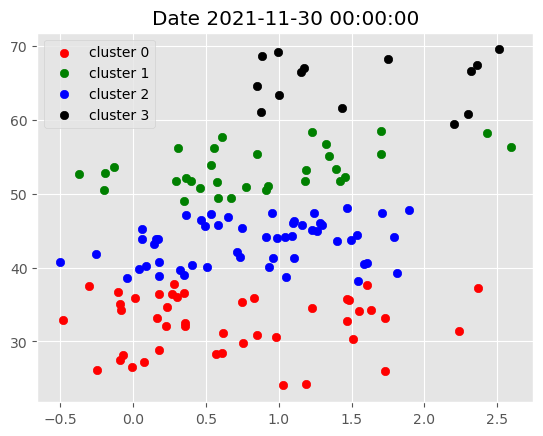

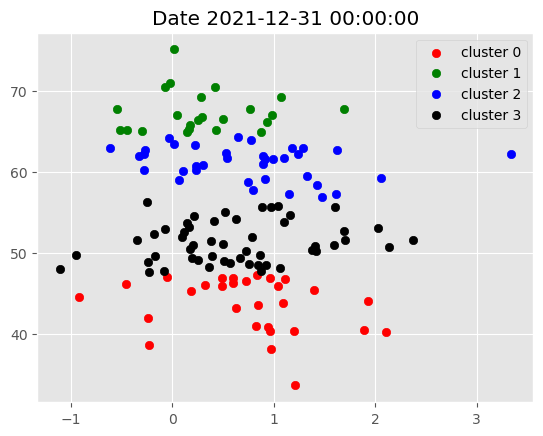

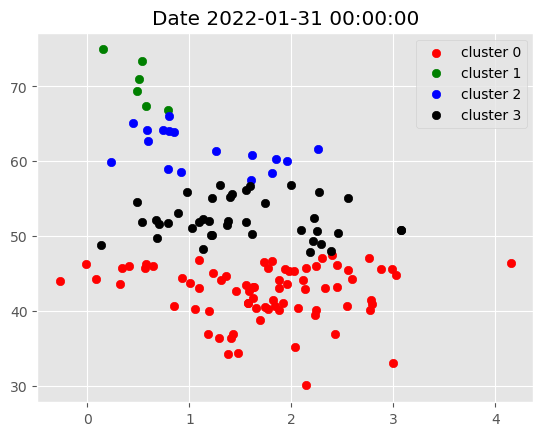

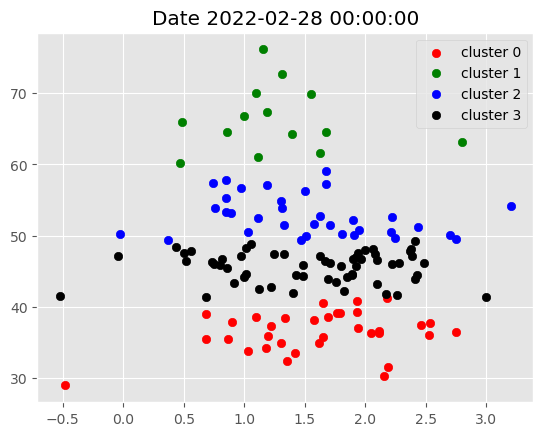

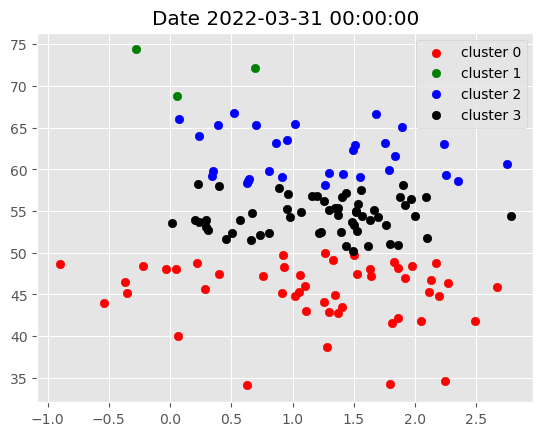

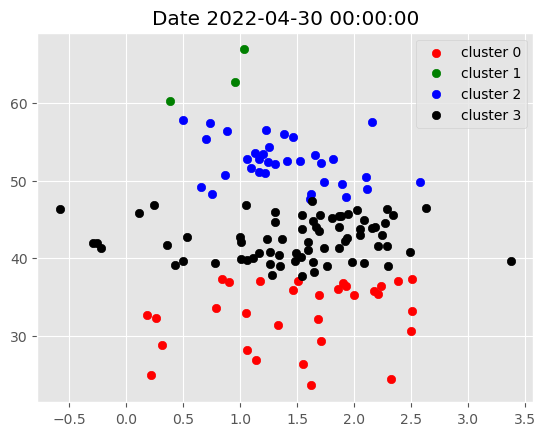

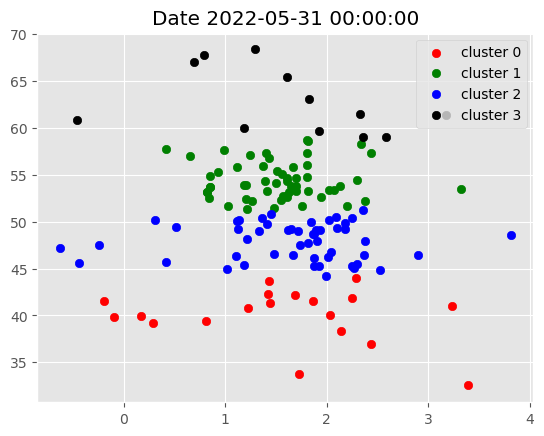

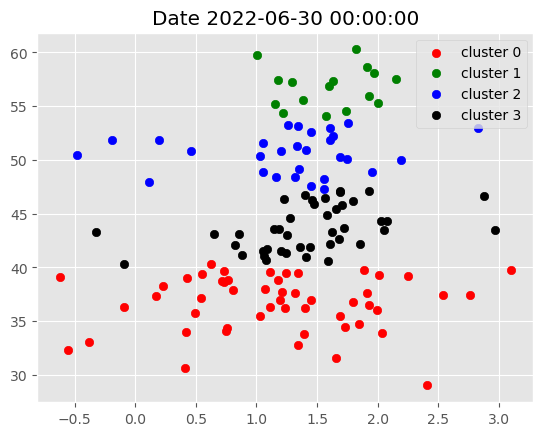

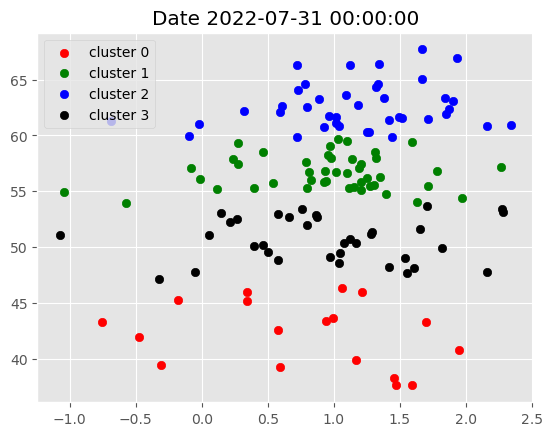

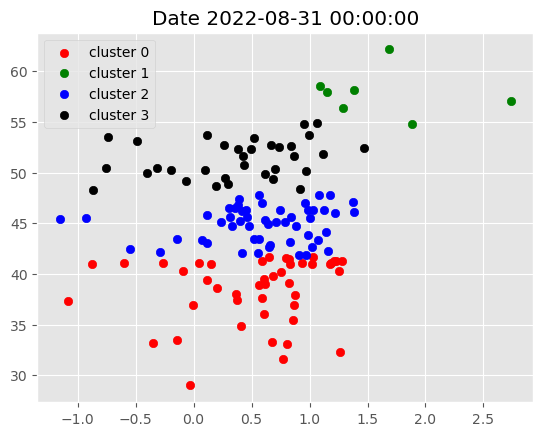

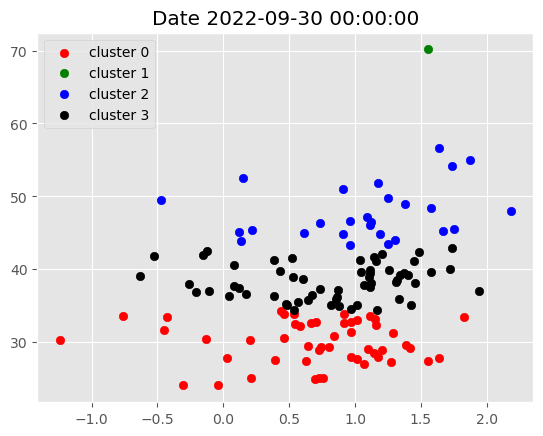

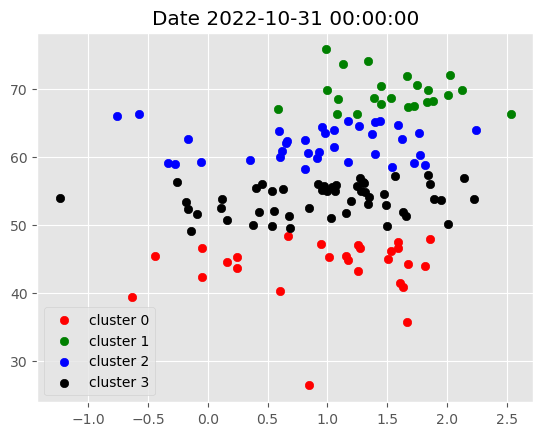

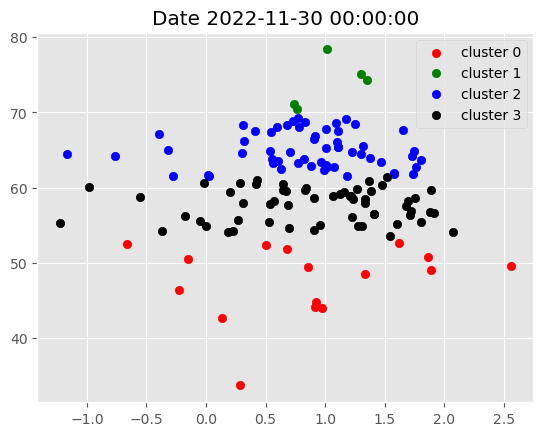

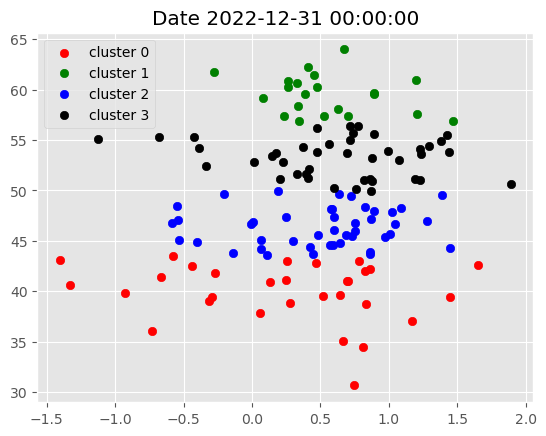

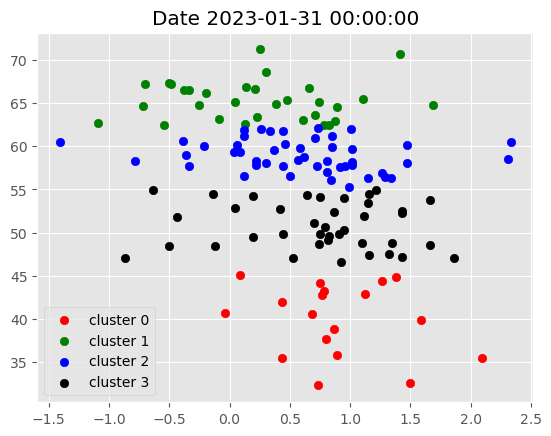

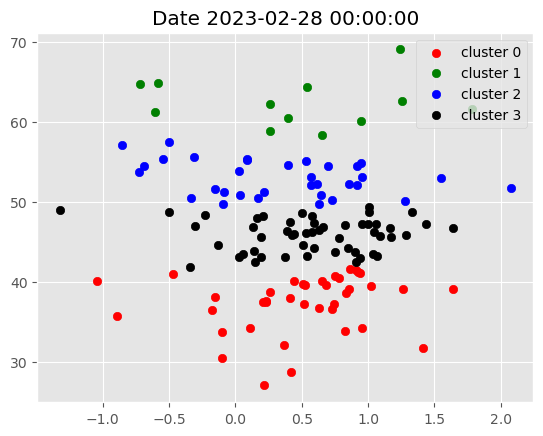

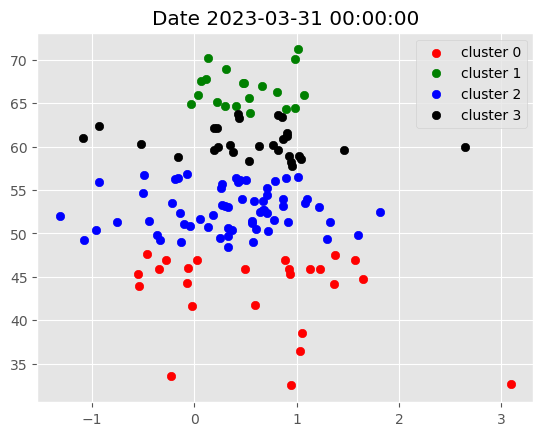

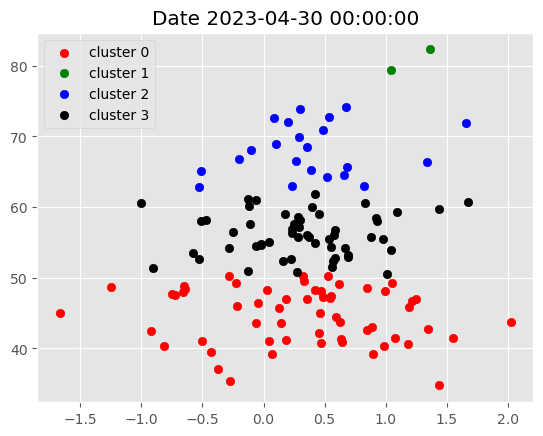

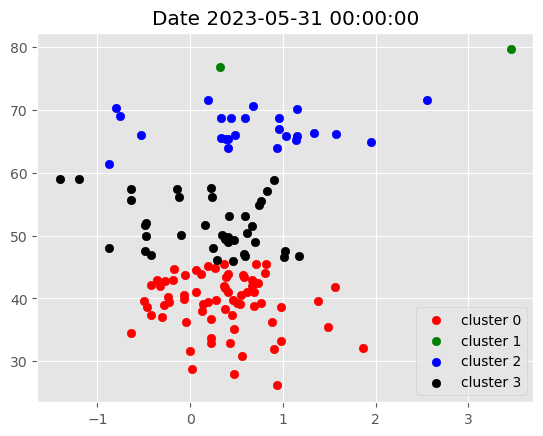

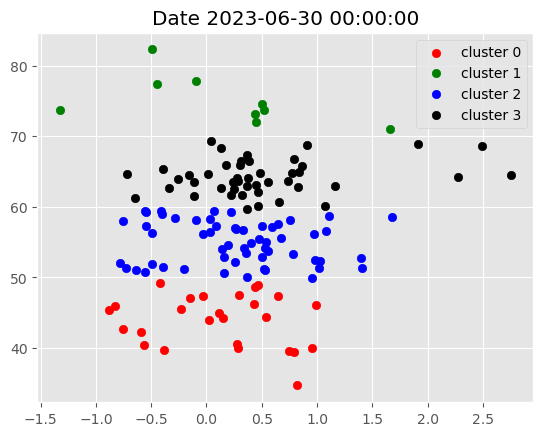

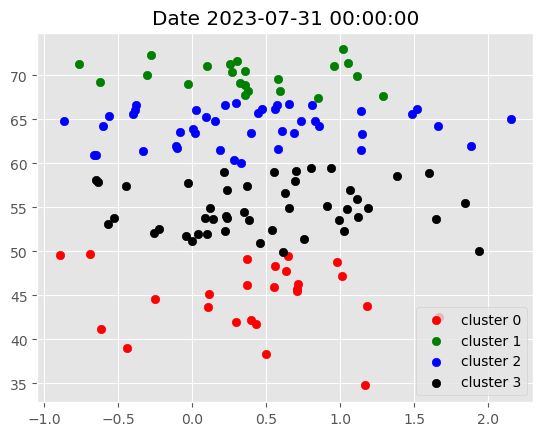

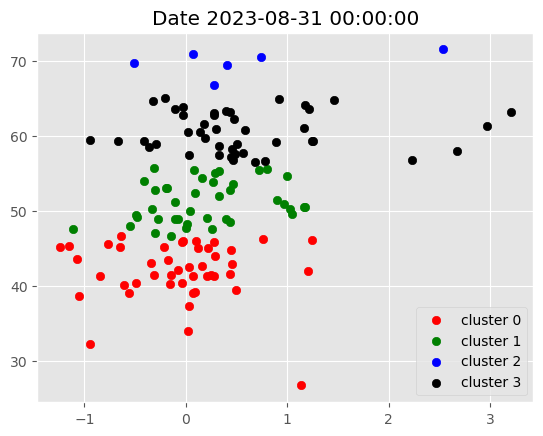

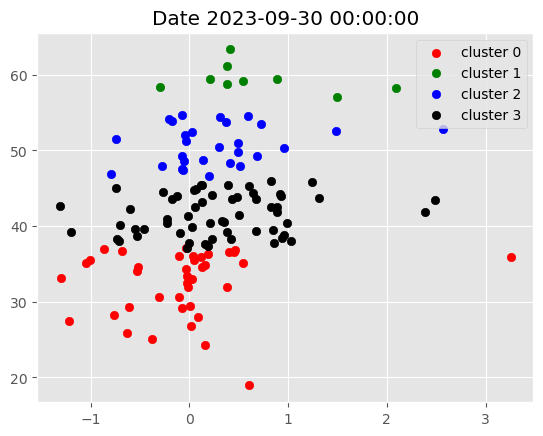

In [13]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [14]:
filtered_df = data[data['cluster']==1].copy()# from the aobve it is clear cluster 1 is perofmirng ht ebst
filtered_df = filtered_df.reset_index(level=1) # tunring tickers into a normal colums
filtered_df.index = filtered_df.index+pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])
dates = filtered_df.index.get_level_values('date').unique().tolist() # all set of unique dates
fixed_dates = {}
for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()# take all the stocks correspconding to a date and yeet them into the dictionary
    
    # now we got the correct dates for every stock!
fixed_dates

{'2017-11-01': ['INTC', 'MSFT'],
 '2017-12-01': ['AXP',
  'AZO',
  'BA',
  'BLK',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'JPM',
  'KR',
  'MAR',
  'MMM',
  'NKE',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['ABT',
  'ACN',
  'AXP',
  'AZO',
  'BAC',
  'BLK',
  'BRK-B',
  'CL',
  'COP',
  'COST',
  'CSCO',
  'DAL',
  'DG',
  'DLTR',
  'EOG',
  'INTC',
  'JPM',
  'KR',
  'LMT',
  'MO',
  'MPC',
  'MSFT',
  'NKE',
  'NXPI',
  'PEP',
  'PG',
  'SCHW',
  'SHW',
  'SLB',
  'STZ',
  'T',
  'TGT',
  'TJX',
  'UAL',
  'UNP',
  'V',
  'VZ',
  'WFC',
  'WMT',
  'WYNN'],
 '2018-02-01': ['AMZN'],
 '2018-03-01': ['ABBV',
  'ABT',
  'ACN',
  'AMAT',
  'AMGN',
  'BAC',
  'BLK',
  'BMY',
  'BRK-B',
  'BSX',
  'CMG',
  'COST',
  'EA',
  'EBAY',
  'GD',
  'GOOG',
  'GS',
  'HUM',
  'ISRG',
  'JPM',
  'LMT',
  'LRCX',
  'MAR',
  'MDLZ',
  'MS',
  'MSFT',
  'NKE',
  'NVDA',
  'ORCL',
  'PFE',
  'PNC',
  'PYPL',
  'RTX',
  'SCHW',
  'TGT',
  'TSLA',
  'T

In [372]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  153 of 153 completed


Adj Close                                                 \
                  AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2016-10-31  39.134327   26.316149   41.419556  34.821724  104.783096   
2016-11-01  38.363201   25.840994   41.917068  34.653122  104.692986   
2016-11-02  38.276459   25.864183   42.169540  34.342529  106.919510   
2016-11-03  38.054203   25.586943   41.501225  34.058559  105.423119   
2016-11-04  38.402088   25.356310   41.612629  34.688618  105.675537   
...               ...         ...         ...        ...         ...   
2023-09-25  12.910000  176.080002  154.649994  97.470001  316.989990   
2023-09-26  12.700000  171.960007  153.910004  96.230003  310.609985   
2023-09-27  12.610000  170.429993  153.130005  95.529999  314.380005   
2023-09-28  12.920000  170.690002  152.250000  98.120003  300.769989   
2023-09-29  12.810000  171.210007  149.059998  96.849998  307.109985   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-10-31  107.510002   75.138802   72.279999  51.253304   26.757372  ...   
2016-11-01  106.870003   75.017982   70.099998  50.406013   26.591753  ...   
2016-11-02  105.889999   77.658951   68.680000  50.298012   26.306513  ...   
2016-11-03  107.169998   77.097977   67.610001  48.304379   26.012074  ...   
2016-11-04  106.199997   76.882202   69.440002  47.664745   25.966064  ...   
...                ...         ...         ...        ...         ...  ...   
2023-09-25  511.600006  240.020004  205.669998  62.130001  136.589996  ...   
2023-09-26  506.299988  237.240005  201.660004  61.259998  134.080002  ...   
2023-09-27  502.600006  242.630005  202.279999  61.009998  135.059998  ...   
2023-09-28  504.670013  243.309998  207.889999  61.279999  138.220001  ...   
2023-09-29  509.899994  240.580002  206.910004  60.599998  138.449997  ...   

              Volume                                                           \
                   V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2016-10-31  10024000  4969500  1928200  12459400   4662100  3363200  20115900   
2016-11-01  10881500  7816800  2458200  13229400   5130800  3821100  20020200   
2016-11-02   9170900  7317600  2580400  16488200   9783100  4216200  19566600   
2016-11-03   7563100  3855900  2371000  12605100   4586500  3192600  14982700   
2016-11-04   7588100  3729900  1902100  14410200   7023900  2705600  27391600   
...              ...      ...      ...       ...       ...      ...       ...   
2023-09-25   5921600  3241900   698100  17616900   6891000  2685900  10624000   
2023-09-26   6193200  4936800   633600  18841600   7570500  3571100  15219400   
2023-09-27   6006700  3644000   860600  22083500  10182900  2547800  11815500   
2023-09-28   4203900  3587300   578900  18772100   7291500  3282000  12454600   
2023-09-29   6044200  4302200   896800  19759400  25659100  2512000  13119100   

                                        
                WMT     WYNN       XOM  
Date                                    
2016-10-31  6389000  1341600  16663800  
2016-11-01  8838600  3722300  13050600  
2016-11-02  7645300  2542400  11226100  
2016-11-03  6803900  9050400   8836500  
2016-11-04  7262100  3223800  13877100  
...             ...      ...       ...  
2023-09-25  3486500  1387800  11316000  
2023-09-26  4811900  1454000  11805400  
2023-09-27  5237000  2050000  23976200  
2023-09-28  3872400  1290400  16808100  
2023-09-29  6279300  1326800  18810700  

[1740 rows x 918 columns]

In [16]:
!pip install pyportfolioopt

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252) 
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    weights = ef.max_sharpe()
    return ef.clean_weights()

In [373]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2017-11-01,0.001481
2017-11-02,0.002892
2017-11-03,0.006382
2017-11-06,0.002932
2017-11-07,0.002917
...,...
2023-09-25,0.003587
2023-09-26,-0.011112
2023-09-27,0.004989


In [374]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2017-11-01,0.001481,0.001321
2017-11-02,0.002892,0.000388
2017-11-03,0.006382,0.003333
2017-11-06,0.002932,0.001547
2017-11-07,0.002917,-0.000696
...,...,...
2023-09-25,0.003587,0.004196
2023-09-26,-0.011112,-0.014800
2023-09-27,0.004989,0.000399
2023-09-28,0.007681,0.005781


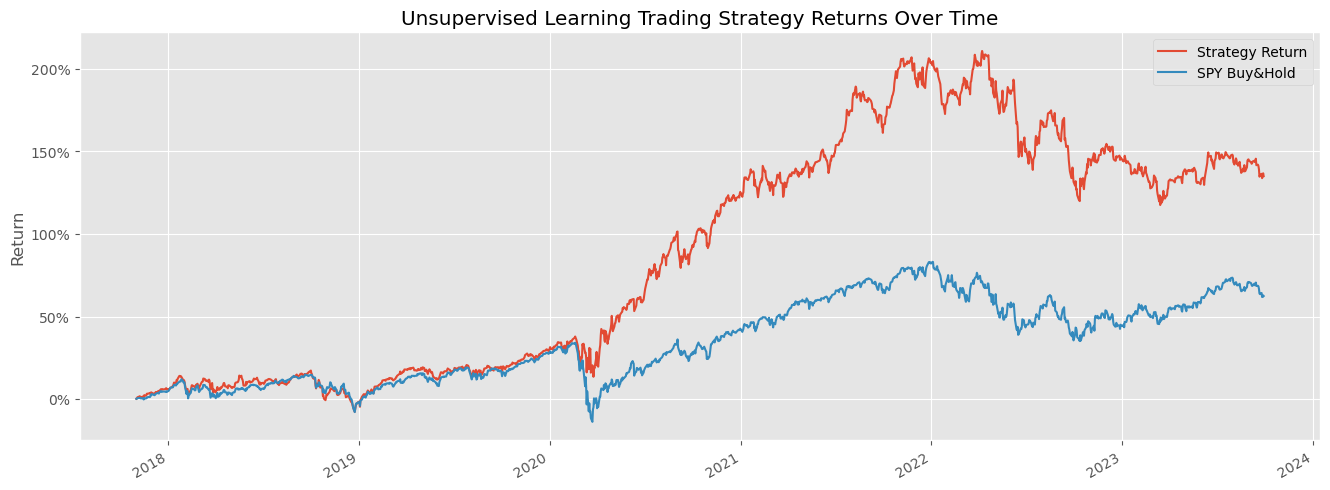

In [375]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


In [14]:
#NOW WE WILL MAKE THE TWITTER BOT

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')

data_folder = 'C:/Users/user/Desktop/Python Scripts'
sentiment_df = pd.read_csv('C:/Users/CHANDRASHEKHAR BASU/Desktop/Python Scripts/sentiment_data.csv') # extracting data set
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])# converting the date time to a date time object
sentiment_df = sentiment_df.set_index(['date', 'symbol'])# using these as the index for ease of convertion
sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']
# Engagement ratio is what we will use to determine 
sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20)&(sentiment_df['twitterComments']>10)]
# filtering for relevant data
sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

In [15]:
aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                    [['engagement_ratio']].mean())
# to make it easier on ourselves we will use monthly data, so we aggragte by month. We un index the symbol and thenf or every month we get the mean
aggragated_df['rank'] = (aggragated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))
# we rank different instances 
aggragated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

In [16]:
filtered_df = aggragated_df[aggragated_df['rank']<6].copy()
# now that we got our ranks we will filter for the best perofrming sticks
filtered_df = filtered_df.reset_index(level=1)
# we reset it so symbol is only 1
filtered_df.index = filtered_df.index+pd.DateOffset(1)
# since index is date, we are offsetting so that we can predict a day in advanced
filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

filtered_df.head(20)

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
2022-01-01 D               0.801994   5.0
           FCX             0.841220   4.0
           L               6.507246   1.0
           LUV             1.303215   2.0
           MA              0.883401   3.0
2022-02-01 AMD             0.715556   4.0
           D               1.136678   1.0
           FCX             0.655237   5.0
           LUV             1.035258   2.0
           MA              0.729063   3.0
2022-03-01 FCX             1.138332   2.0
           GILD            0.530886   5.0
           LUV             1.574377   1.0
           MRO             0.581748   4.0
           OXY             1.025579   3.0

In [17]:
dates = filtered_df.index.get_level_values('date').unique().tolist()
# getting all the unique dates to account for repetitions
fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    # basically we are extracting the top 5 best stocks for each date
fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

In [37]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()
prices_df = yf.download(tickers=stocks_list,
                        start='2021-01-01',
                        end='2023-03-01')
# we are donwlaoding historical information for all the stocks in our data set
#Download fresh stock prices for only selected/shortlisted stocks
prices_df


[*********************100%***********************]  85 of 85 completed

2 Failed downloads:
['ATVI', 'MRO']: YFTzMissingError('possibly delisted; no timezone found')


Price      Adj Close           Close                                 \
Ticker          ATVI MRO           A    AAL         AAP        AAPL   
Date                                                                  
2021-01-04       NaN NaN  115.095337  15.13  141.324203  126.239693   
2021-01-05       NaN NaN  116.036354  15.43  141.171509  127.800461   
2021-01-06       NaN NaN  119.218353  15.52  149.327240  123.498528   
2021-01-07       NaN NaN  122.390656  15.38  150.602722  127.712669   
2021-01-08       NaN NaN  123.263763  15.13  152.749451  128.814987   
...              ...  ..         ...    ...         ...         ...   
2023-02-22       NaN NaN  139.492371  15.56  135.735291  147.230240   
2023-02-23       NaN NaN  140.591965  15.87  134.213638  147.714676   
2023-02-24       NaN NaN  138.628387  15.56  131.227158  145.055038   
2023-02-27       NaN NaN  139.590515  15.63  132.909454  146.251373   
2023-02-28       NaN NaN  139.384369  15.98  137.001724  145.747116   

Price                                                     ...   Volume  \
Ticker            ABBV         ABT        AEP        AES  ...      RCL   
Date                                                      ...            
2021-01-04   87.365021  100.130608  68.997749  19.576611  ...  5732800   
2021-01-05   88.268425  101.369484  68.904648  20.233656  ...  4029500   
2021-01-06   87.505913  101.158432  69.454674  21.042332  ...  3612500   
2021-01-07   88.442482  102.140381  67.601540  20.831739  ...  3993700   
2021-01-08   88.906624  102.424866  67.000725  21.412975  ...  3104200   
...                ...         ...        ...        ...  ...      ...   
2023-02-22  137.257950   97.741966  83.101845  22.672947  ...  2044600   
2023-02-23  138.533356   97.608711  83.001190  22.672947  ...  2066600   
2023-02-24  139.116348   95.619423  82.744995  22.610437  ...  2875100   
2023-02-27  140.546600   94.962669  82.415596  22.217518  ...  2459700   
2023-02-28  140.200409   96.818710  80.494064  22.038923  ...  3662300   

Price                                                                          \
Ticker         REGN       SLB      STZ         T      TMO       TSLA      TSN   
Date                                                                            
2021-01-04   911100   8743400  1202600  86700816  2220400  145914600  2177400   
2021-01-05   797700  16256600  1530200  83054520  2046700   96735600  2297100   
2021-01-06  1434700  19456300  1861700  73455520  2112300  134100000  1942200   
2021-01-07  1126600  14502400  2537100  71265359  2144400  154496700  2969400   
2021-01-08  1018800  11951900  1595400  72471656  2221700  225166500  2672400   
...             ...       ...      ...       ...      ...        ...      ...   
2023-02-22   415500   9181100  1092200  25308800  1705300  191828500  4217700   
2023-02-23   553300   6324500   979700  24845800  1160200  146360000  3403500   
2023-02-24   525900   8458700   702900  29138100   852600  142228100  2439300   
2023-02-27   557100   6287000   608200  22981100  1110600  161028300  3922200   
2023-02-28   622700  10634200  1136900  34154800  1188800  153144900  3556300   

Price                           
Ticker             V       XOM  
Date                            
2021-01-04  10318300  27764700  
2021-01-05   6869700  44035100  
2021-01-06   7206200  36484800  
2021-01-07  10967900  29528100  
2021-01-08   6513000  28628200  
...              ...       ...  
2023-02-22   4621800  13973800  
2023-02-23   5533800  11289400  
2023-02-24   4414400  14351000  
2023-02-27   4255300  11710500  
2023-02-28   5385400  18107000  

[542 rows x 427 columns]

In [38]:
#prices_df = prices_df.dropna(axis=1, how='all')
prices_df['Close']

Ticker,A,AAL,AAP,AAPL,ABBV,ABT,AEP,AES,ALB,AMD,...,RCL,REGN,SLB,STZ,T,TMO,TSLA,TSN,V,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,115.095337,15.13,141.324203,126.239693,87.365021,100.130608,68.997749,19.576611,145.072205,92.300003,...,69.949753,481.528900,20.032066,201.212372,16.057775,466.433350,243.256668,55.558548,210.791306,34.533432
2021-01-05,116.036354,15.43,141.171509,127.800461,88.268425,101.369484,68.904648,20.233656,154.862167,92.769997,...,71.759819,482.117310,21.108963,201.351639,15.959593,472.265991,245.036667,55.514793,207.645355,36.197678
2021-01-06,119.218353,15.52,149.327240,123.498528,87.505913,101.158432,69.454674,21.042332,166.429565,90.330002,...,71.413620,468.794128,22.277121,207.692322,16.270496,479.670502,251.993332,57.185925,205.815811,37.121349
2021-01-07,122.390656,15.38,150.602722,127.712669,88.442482,102.140381,67.601540,20.831739,174.888840,95.160004,...,73.174248,479.873505,22.706049,212.473373,16.314133,494.617859,272.013336,56.529728,206.967728,37.412594
2021-01-08,123.263763,15.13,152.749451,128.814987,88.906624,102.424866,67.000725,21.412975,174.983917,94.580002,...,72.175240,497.355164,22.669546,213.717361,16.201628,506.451263,293.339996,56.022263,208.555237,37.828659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-22,139.492371,15.56,135.735291,147.230240,137.257950,97.741966,83.101845,22.672947,237.693375,76.610001,...,70.731140,746.017822,49.624378,212.504211,16.782984,544.427246,200.860001,56.604359,216.331100,101.544853
2023-02-23,140.591965,15.87,134.213638,147.714676,138.533356,97.608711,83.001190,22.672947,244.830490,79.750000,...,70.928955,757.565857,50.486012,215.833557,16.757004,546.958679,202.070007,57.172783,217.422501,102.479507
2023-02-24,138.628387,15.56,131.227158,145.055038,139.116348,95.619423,82.744995,22.610437,240.654297,78.089996,...,69.405731,754.903198,51.054119,214.388916,16.661743,538.857666,196.880005,56.136787,215.869003,102.488770


In [41]:
returns_df = np.log(prices_df['Close']).diff()
returns_df

Ticker,A,AAL,AAP,AAPL,ABBV,ABT,AEP,AES,ALB,AMD,...,RCL,REGN,SLB,STZ,T,TMO,TSLA,TSN,V,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,0.008143,0.019634,-0.001081,0.012288,0.010287,0.012297,-0.001350,0.033012,0.065304,0.005079,...,0.025548,0.001221,0.052363,0.000692,-0.006133,0.012427,0.007291,-0.000788,-0.015037,0.047067
2021-01-06,0.027053,0.005816,0.056165,-0.034241,-0.008676,-0.002084,0.007951,0.039189,0.072037,-0.026654,...,-0.004836,-0.028024,0.053862,0.031005,0.019293,0.015557,0.027995,0.029658,-0.008850,0.025197
2021-01-07,0.026261,-0.009062,0.008505,0.033554,0.010646,0.009660,-0.027044,-0.010058,0.049578,0.052090,...,0.024355,0.023359,0.019071,0.022759,0.002678,0.030686,0.076448,-0.011541,0.005581,0.007815
2021-01-08,0.007108,-0.016388,0.014154,0.008594,0.005234,0.002781,-0.008927,0.027519,0.000543,-0.006114,...,-0.013747,0.035782,-0.001609,0.005838,-0.006920,0.023643,0.075481,-0.009018,0.007641,0.011060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-22,-0.009387,-0.008320,-0.003961,0.002892,-0.008789,-0.009305,-0.000330,-0.007064,0.018387,-0.002086,...,-0.003490,0.002088,-0.018713,-0.004447,0.008811,-0.004312,0.017528,0.016659,-0.002723,-0.013038
2023-02-23,0.007852,0.019727,-0.011274,0.003285,0.009249,-0.001364,-0.001212,0.000000,0.029585,0.040169,...,0.002793,0.015361,0.017214,0.015546,-0.001549,0.004639,0.006006,0.009992,0.005032,0.009162
2023-02-24,-0.014065,-0.019727,-0.022503,-0.018169,0.004199,-0.020591,-0.003091,-0.002761,-0.017205,-0.021035,...,-0.021709,-0.003521,0.011190,-0.006716,-0.005701,-0.014922,-0.026020,-0.018287,-0.007171,0.000090


In [42]:

# calculating normalized returns 
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    cols = fixed_dates[start_date]
    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
    # in Laymens terms, temp df stores the mean returns for all the top 5 selected stocks from the start date to the next month and put it under potfolio return
    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
portfolio_df

,portfolio_return
Date,
2021-12-01,-0.016417
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
...,...
2023-02-22,-0.007870
2023-02-23,-0.007323
2023-02-24,-0.009463


In [47]:
qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                     end='2023-03-01')
# simply getting Nasdaq stocks for comparison purposes
qqq_ret = pd.DataFrame()
qqq_ret['nasdaq_return'] = np.log(qqq_df['Close']).diff()

portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)
# merging for comparison purposes
portfolio_df

[*********************100%***********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.016417,-0.017159
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017542
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
...,...,...
2023-02-22,-0.007870,0.000748
2023-02-23,-0.007323,0.008696
2023-02-24,-0.009463,-0.016886


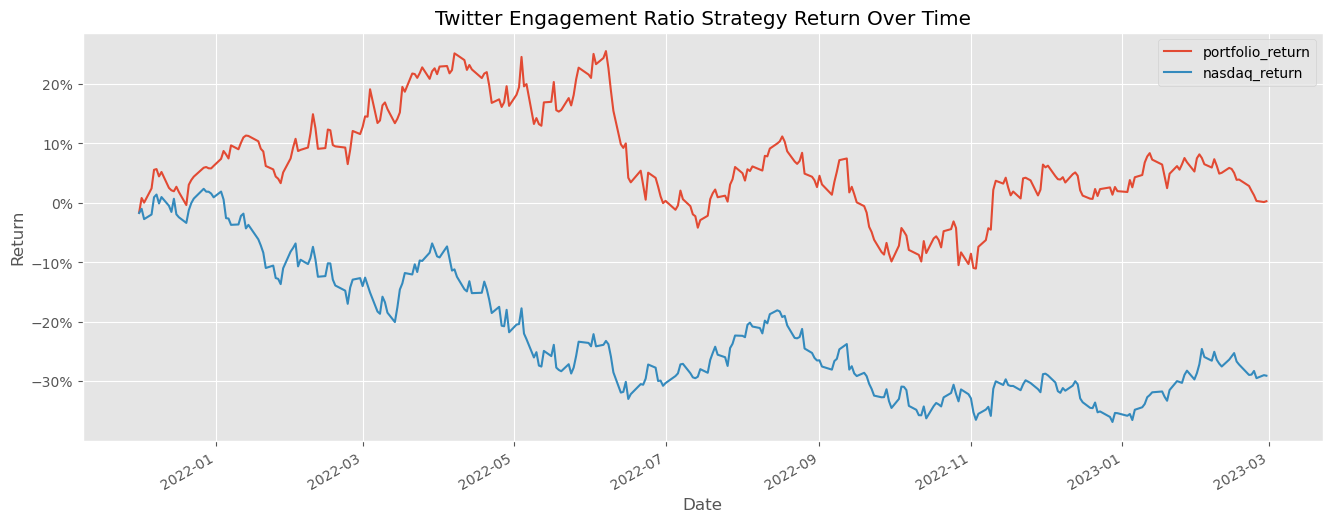

In [49]:
import matplotlib.ticker as mtick
portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Bot performance')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()

In [51]:
!pip install arch

   ---------------------------------------- 0.0/925.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/925.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/925.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/925.2 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/925.2 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/925.2 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/925.2 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/925.2 kB ? eta -:--:--
   --------------------- ---------------- 524.3/925.2 kB 363.9 kB/s eta 0:00:02
   --------------------- ---------------- 524.3/925.2 kB 363.9 kB/s eta 0:00:02
   -------------------------------- ----- 786.4/925.2 kB 422.3 kB/s eta 0:00:01
   -------------------------------------- 925.2/925.2 kB 453.7 kB/s eta 0:00:00


In [1]:
import matplotlib.pyplot as plt
from arch import arch_model
import pandas_ta
import pandas as pd
import numpy as np
import os

data_folder = 'C:/Users/CHANDRASHEKHAR BASU/Desktop/Python Scripts'
daily_df = pd.read_csv(data_folder+ '/simulated_daily_data.csv')
daily_df = daily_df.drop('Unnamed: 7', axis=1) # Worthless axis
daily_df['Date'] = pd.to_datetime(daily_df['Date']) # convertin to time object
daily_df = daily_df.set_index('Date') # setting dat eas index


intraday_5min_df = pd.read_csv(data_folder+ '/simulated_5min_data.csv')
intraday_5min_df = intraday_5min_df.drop('Unnamed: 6', axis=1)
intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])
intraday_5min_df = intraday_5min_df.set_index('datetime')
intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df.index.date)
intraday_5min_df
daily_df


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,116.466003,117.043503,113.105499,114.333504,114.333504,2.105680e+07
2014-09-18,114.214996,114.214996,103.276001,106.110001,106.110001,3.448320e+07
2014-09-19,106.025749,106.958748,96.133003,98.698998,98.698998,3.791970e+07
2014-09-20,98.668251,105.823998,97.470749,102.225998,102.225998,3.686360e+07
2014-09-21,102.021248,103.106499,98.295250,99.705254,99.705254,2.658010e+07
...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09


In [75]:
daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff() # logarithmic returns if held
daily_df['variance'] = daily_df['log_ret'].rolling(180).var()# variance of said returns over a 180 day range
daily_df = daily_df['2020':]# just removing shit from ebfore 2020

daily_df

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance
Date,,,,,,,,
2020-01-01,1798.723022,1813.582642,1793.736084,1800.043579,1800.043579,1.856566e+10,NaN,NaN
2020-01-02,1800.637817,1803.038818,1733.817505,1746.367554,1746.367554,2.080208e+10,-0.030273,NaN
2020-01-03,1746.107178,1853.428833,1728.749023,1836.221069,1836.221069,2.811148e+10,0.050172,NaN
2020-01-04,1836.343872,1856.846436,1827.378540,1852.664185,1852.664185,1.844427e+10,0.008915,NaN
2020-01-05,1852.612915,1886.124268,1850.133911,1852.829346,1852.829346,1.972507e+10,0.000089,NaN
...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384


In [76]:


def predict_volatility(x):
    best_model = arch_model(y=x,
                            p=1,
                            q=3).fit(update_freq=5,
                                     disp='off')
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1,0]
    print(x.index[-1])
    return variance_forecast
daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x))
daily_df = daily_df.dropna()

2020-06-29 00:00:00
2020-06-30 00:00:00
2020-07-01 00:00:00
2020-07-02 00:00:00
2020-07-03 00:00:00
2020-07-04 00:00:00
2020-07-05 00:00:00
2020-07-06 00:00:00
2020-07-07 00:00:00
2020-07-08 00:00:00
2020-07-09 00:00:00
2020-07-10 00:00:00
2020-07-11 00:00:00
2020-07-12 00:00:00
2020-07-13 00:00:00
2020-07-14 00:00:00
2020-07-15 00:00:00
2020-07-16 00:00:00
2020-07-17 00:00:00
2020-07-18 00:00:00
2020-07-19 00:00:00
2020-07-20 00:00:00
2020-07-21 00:00:00
2020-07-22 00:00:00
2020-07-23 00:00:00
2020-07-24 00:00:00
2020-07-25 00:00:00
2020-07-26 00:00:00
2020-07-27 00:00:00
2020-07-28 00:00:00
2020-07-29 00:00:00
2020-07-30 00:00:00
2020-07-31 00:00:00
2020-08-01 00:00:00
2020-08-02 00:00:00
2020-08-03 00:00:00
2020-08-04 00:00:00
2020-08-05 00:00:00
2020-08-06 00:00:00
2020-08-07 00:00:00
2020-08-08 00:00:00
2020-08-09 00:00:00
2020-08-10 00:00:00
2020-08-11 00:00:00
2020-08-12 00:00:00
2020-08-13 00:00:00
2020-08-14 00:00:00
2020-08-15 00:00:00
2020-08-16 00:00:00
2020-08-17 00:00:00


C:\Users\CHANDRASHEKHAR BASU\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\CHANDRASHEKHAR BASU\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\CHANDRASHEKHAR BASU\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2020-12-24 00:00:00
2020-12-25 00:00:00
2020-12-26 00:00:00
2020-12-27 00:00:00
2020-12-28 00:00:00
2020-12-29 00:00:00
2020-12-30 00:00:00


C:\Users\CHANDRASHEKHAR BASU\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2020-12-31 00:00:00
2021-01-01 00:00:00
2021-01-02 00:00:00
2021-01-03 00:00:00
2021-01-04 00:00:00


C:\Users\CHANDRASHEKHAR BASU\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\CHANDRASHEKHAR BASU\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\CHANDRASHEKHAR BASU\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-01-05 00:00:00
2021-01-06 00:00:00
2021-01-07 00:00:00
2021-01-08 00:00:00
2021-01-09 00:00:00
2021-01-10 00:00:00
2021-01-11 00:00:00
2021-01-12 00:00:00
2021-01-13 00:00:00
2021-01-14 00:00:00
2021-01-15 00:00:00
2021-01-16 00:00:00
2021-01-17 00:00:00
2021-01-18 00:00:00
2021-01-19 00:00:00
2021-01-20 00:00:00
2021-01-21 00:00:00
2021-01-22 00:00:00
2021-01-23 00:00:00
2021-01-24 00:00:00
2021-01-25 00:00:00
2021-01-26 00:00:00
2021-01-27 00:00:00
2021-01-28 00:00:00
2021-01-29 00:00:00
2021-01-30 00:00:00
2021-01-31 00:00:00
2021-02-01 00:00:00
2021-02-02 00:00:00
2021-02-03 00:00:00
2021-02-04 00:00:00
2021-02-05 00:00:00
2021-02-06 00:00:00
2021-02-07 00:00:00
2021-02-08 00:00:00
2021-02-09 00:00:00
2021-02-10 00:00:00
2021-02-11 00:00:00
2021-02-12 00:00:00
2021-02-13 00:00:00
2021-02-14 00:00:00
2021-02-15 00:00:00
2021-02-16 00:00:00
2021-02-17 00:00:00
2021-02-18 00:00:00
2021-02-19 00:00:00
2021-02-20 00:00:00
2021-02-21 00:00:00
2021-02-22 00:00:00
2021-02-23 00:00:00


C:\Users\CHANDRASHEKHAR BASU\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-03-23 00:00:00
2021-03-24 00:00:00
2021-03-25 00:00:00
2021-03-26 00:00:00
2021-03-27 00:00:00
2021-03-28 00:00:00
2021-03-29 00:00:00
2021-03-30 00:00:00
2021-03-31 00:00:00
2021-04-01 00:00:00
2021-04-02 00:00:00
2021-04-03 00:00:00
2021-04-04 00:00:00
2021-04-05 00:00:00
2021-04-06 00:00:00
2021-04-07 00:00:00
2021-04-08 00:00:00
2021-04-09 00:00:00
2021-04-10 00:00:00
2021-04-11 00:00:00
2021-04-12 00:00:00
2021-04-13 00:00:00
2021-04-14 00:00:00
2021-04-15 00:00:00
2021-04-16 00:00:00
2021-04-17 00:00:00
2021-04-18 00:00:00
2021-04-19 00:00:00
2021-04-20 00:00:00
2021-04-21 00:00:00
2021-04-22 00:00:00
2021-04-23 00:00:00
2021-04-24 00:00:00
2021-04-25 00:00:00
2021-04-26 00:00:00
2021-04-27 00:00:00
2021-04-28 00:00:00
2021-04-29 00:00:00
2021-04-30 00:00:00
2021-05-01 00:00:00
2021-05-02 00:00:00
2021-05-03 00:00:00
2021-05-04 00:00:00
2021-05-05 00:00:00
2021-05-06 00:00:00
2021-05-07 00:00:00
2021-05-08 00:00:00
2021-05-09 00:00:00
2021-05-10 00:00:00
2021-05-11 00:00:00


C:\Users\CHANDRASHEKHAR BASU\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2022-04-15 00:00:00
2022-04-16 00:00:00
2022-04-17 00:00:00
2022-04-18 00:00:00
2022-04-19 00:00:00
2022-04-20 00:00:00
2022-04-21 00:00:00
2022-04-22 00:00:00
2022-04-23 00:00:00
2022-04-24 00:00:00
2022-04-25 00:00:00
2022-04-26 00:00:00
2022-04-27 00:00:00
2022-04-28 00:00:00
2022-04-29 00:00:00
2022-04-30 00:00:00
2022-05-01 00:00:00
2022-05-02 00:00:00
2022-05-03 00:00:00
2022-05-04 00:00:00
2022-05-05 00:00:00
2022-05-06 00:00:00
2022-05-07 00:00:00
2022-05-08 00:00:00
2022-05-09 00:00:00
2022-05-10 00:00:00
2022-05-11 00:00:00
2022-05-12 00:00:00
2022-05-13 00:00:00
2022-05-14 00:00:00
2022-05-15 00:00:00
2022-05-16 00:00:00
2022-05-17 00:00:00
2022-05-18 00:00:00
2022-05-19 00:00:00
2022-05-20 00:00:00
2022-05-21 00:00:00
2022-05-22 00:00:00
2022-05-23 00:00:00
2022-05-24 00:00:00
2022-05-25 00:00:00
2022-05-26 00:00:00
2022-05-27 00:00:00
2022-05-28 00:00:00
2022-05-29 00:00:00
2022-05-30 00:00:00
2022-05-31 00:00:00
2022-06-01 00:00:00
2022-06-02 00:00:00
2022-06-03 00:00:00


C:\Users\CHANDRASHEKHAR BASU\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2022-06-21 00:00:00
2022-06-22 00:00:00
2022-06-23 00:00:00
2022-06-24 00:00:00
2022-06-25 00:00:00
2022-06-26 00:00:00
2022-06-27 00:00:00
2022-06-28 00:00:00
2022-06-29 00:00:00
2022-06-30 00:00:00
2022-07-01 00:00:00
2022-07-02 00:00:00
2022-07-03 00:00:00
2022-07-04 00:00:00
2022-07-05 00:00:00
2022-07-06 00:00:00
2022-07-07 00:00:00
2022-07-08 00:00:00
2022-07-09 00:00:00
2022-07-10 00:00:00
2022-07-11 00:00:00
2022-07-12 00:00:00
2022-07-13 00:00:00
2022-07-14 00:00:00
2022-07-15 00:00:00
2022-07-16 00:00:00
2022-07-17 00:00:00
2022-07-18 00:00:00
2022-07-19 00:00:00
2022-07-20 00:00:00
2022-07-21 00:00:00
2022-07-22 00:00:00
2022-07-23 00:00:00
2022-07-24 00:00:00
2022-07-25 00:00:00
2022-07-26 00:00:00
2022-07-27 00:00:00
2022-07-28 00:00:00
2022-07-29 00:00:00
2022-07-30 00:00:00
2022-07-31 00:00:00
2022-08-01 00:00:00
2022-08-02 00:00:00
2022-08-03 00:00:00
2022-08-04 00:00:00
2022-08-05 00:00:00
2022-08-06 00:00:00
2022-08-07 00:00:00
2022-08-08 00:00:00
2022-08-09 00:00:00


In [77]:
daily_df

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions
Date,,,,,,,,,
2020-06-29,2285.007324,2309.393311,2260.468994,2297.713623,2297.713623,1.646055e+10,0.005157,0.002473,0.000651
2020-06-30,2296.395264,2304.458984,2271.209473,2284.498291,2284.498291,1.573580e+10,-0.005768,0.002468,0.000877
2020-07-01,2286.496338,2327.438721,2276.183838,2307.081299,2307.081299,1.597155e+10,0.009837,0.002455,0.000618
2020-07-02,2307.784912,2318.740723,2259.155762,2280.852539,2280.852539,1.633892e+10,-0.011434,0.002456,0.000703
2020-07-03,2281.210693,2300.586182,2264.698730,2271.825928,2271.825928,1.307897e+10,-0.003965,0.002456,0.000704
...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286


In [78]:
daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']
# if the prediction is greater than the variance, then the stock boostting $$$
daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()
# average of the premium over 180 day intervalsss
daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium']>x['premium_std'])
                                         else (-1 if (x['prediction_premium']<x['premium_std']*-1) else np.nan),
                                         axis=1)
#Buy if prmium is doing good, esle sell
#daily_df['signal_daily'] = daily_df['signal_daily'].shift()
# this allows us to buy and sell on a day after words
daily_df

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions,prediction_premium,premium_std,signal_daily
Date,,,,,,,,,,,,
2020-06-29,2285.007324,2309.393311,2260.468994,2297.713623,2297.713623,1.646055e+10,0.005157,0.002473,0.000651,-0.736673,NaN,NaN
2020-06-30,2296.395264,2304.458984,2271.209473,2284.498291,2284.498291,1.573580e+10,-0.005768,0.002468,0.000877,-0.644670,NaN,NaN
2020-07-01,2286.496338,2327.438721,2276.183838,2307.081299,2307.081299,1.597155e+10,0.009837,0.002455,0.000618,-0.748360,NaN,NaN
2020-07-02,2307.784912,2318.740723,2259.155762,2280.852539,2280.852539,1.633892e+10,-0.011434,0.002456,0.000703,-0.713818,NaN,NaN
2020-07-03,2281.210693,2300.586182,2264.698730,2271.825928,2271.825928,1.307897e+10,-0.003965,0.002456,0.000704,-0.713493,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334,-0.151792,0.549423,NaN
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292,-0.240812,0.546772,NaN
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286,-0.256793,0.545787,NaN


In [80]:
daily_df['signal_daily'] = daily_df['signal_daily'].shift() # so that we make our decision based on the previous days
#data, not the next!!
daily_df

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions,prediction_premium,premium_std,signal_daily
Date,,,,,,,,,,,,
2020-06-29,2285.007324,2309.393311,2260.468994,2297.713623,2297.713623,1.646055e+10,0.005157,0.002473,0.000651,-0.736673,NaN,NaN
2020-06-30,2296.395264,2304.458984,2271.209473,2284.498291,2284.498291,1.573580e+10,-0.005768,0.002468,0.000877,-0.644670,NaN,NaN
2020-07-01,2286.496338,2327.438721,2276.183838,2307.081299,2307.081299,1.597155e+10,0.009837,0.002455,0.000618,-0.748360,NaN,NaN
2020-07-02,2307.784912,2318.740723,2259.155762,2280.852539,2280.852539,1.633892e+10,-0.011434,0.002456,0.000703,-0.713818,NaN,NaN
2020-07-03,2281.210693,2300.586182,2264.698730,2271.825928,2271.825928,1.307897e+10,-0.003965,0.002456,0.000704,-0.713493,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334,-0.151792,0.549423,NaN
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292,-0.240812,0.546772,NaN
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286,-0.256793,0.545787,NaN


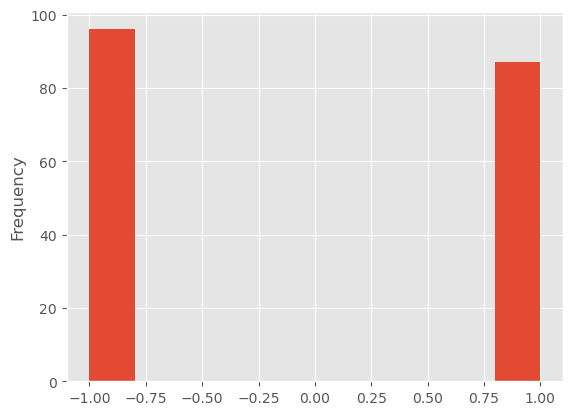

In [81]:
plt.style.use('ggplot')

daily_df['signal_daily'].plot(kind='hist')

plt.show()

In [82]:
final_df = intraday_5min_df.reset_index()\
                            .merge(daily_df[['signal_daily']].reset_index(),
                                   left_on='date',
                                   right_on='Date')\
                            .drop(['date','Date'], axis=1)\
                            .set_index('datetime')
# we are no emrging the daily daat and 5 min data dso that we can make decisiona bsed on both
final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
                                length=20)
# RSI from earlier, higher value means its over bought
final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,0]
# BBand, anothe rindicator liek RSIwith an upper and lower band for compasions sake
final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,2]
final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi']>70)&
                                                            (x['close']>x['uband'])
                                             else (-1 if (x['rsi']<30)&
                                                         (x['close']<x['lband']) else np.nan),
                                             axis=1)
# we are amking decisions only when both RSI and BBands agree
final_df['return'] = np.log(final_df['close']).diff()
# Vanilla returns


,open,low,high,close,volume,signal_daily,rsi,lband,uband,signal_intraday,return
datetime,,,,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN,NaN,NaN,NaN,NaN,0.000018
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN,NaN,NaN,NaN,NaN,0.001269
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN,NaN,NaN,NaN,NaN,0.005589
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN,NaN,NaN,NaN,NaN,-0.000146
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,NaN,62.861699,6677.365065,6715.855435,NaN,0.000128
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,NaN,63.165869,6679.544207,6716.559793,NaN,0.000070
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,NaN,61.954798,6682.379916,6716.534084,NaN,-0.000158


In [83]:
final_df['signal_intraday'].unique()

array([nan,  1., -1.])

In [84]:
final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily']==1)&(x['signal_intraday']==1)
                                        else (1 if (x['signal_daily']==-1)&(x['signal_intraday']==-1) else np.nan),
                                        axis=1)
# so we will hold if both signal daily and signal intra day agree on holding
# else we will sell
final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
                                  .transform(lambda x: x.ffill())
# see, we are holding, so that measn that we can jsut leave them with NaN. We gotta hold!!!!!!
final_df['forward_return'] = final_df['return'].shift(-1)# this is gonna help us calcualte our returnsss
final_df['strategy_return'] = final_df['forward_return']*final_df['return_sign']
# our returns
daily_return_df = final_df.groupby(pd.Grouper(freq='D'))['strategy_return'].sum()# our returns for a day

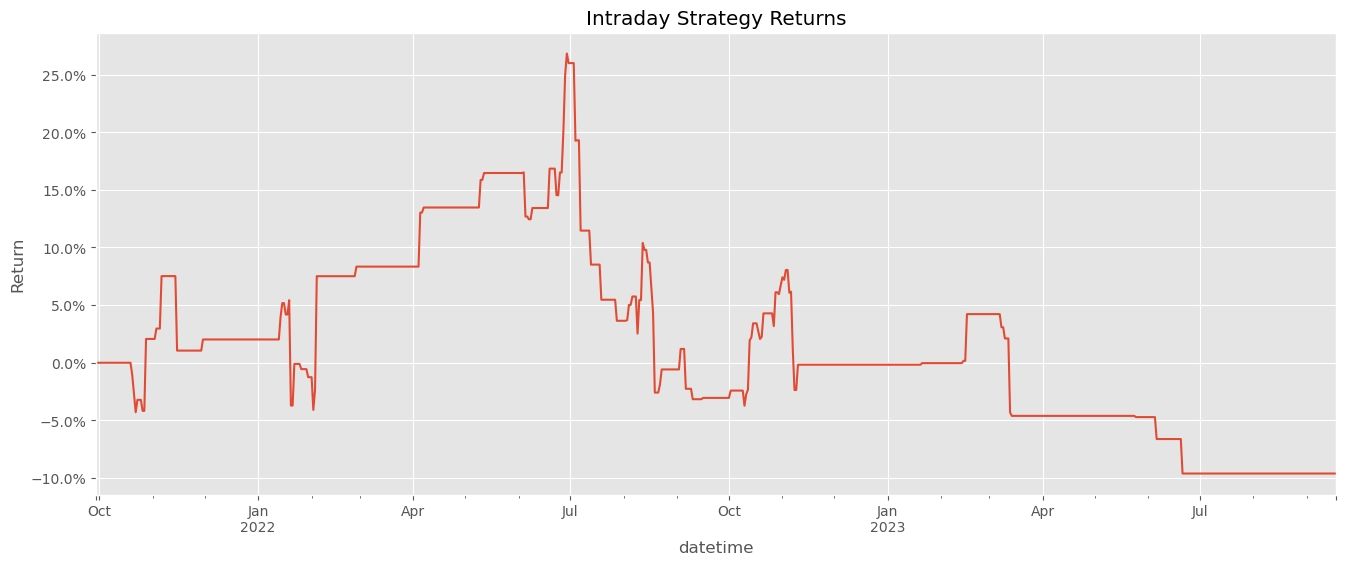

In [85]:
import matplotlib.ticker as mtick

strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)

strategy_cumulative_return.plot(figsize=(16,6))

plt.title('Intraday Strategy Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
                                                                            